In [1]:
# from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename
import math
import scipy.special
from scipy.stats import poisson

Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\slab\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x + b

def proportional(x, m):
    return m*x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y


def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0] , np.sqrt(pcov[0][0])

def expfunc2(p,x):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*math.e**(-(x-p[1])/p[2])

def fitexp2(xdata, ydata, fitparams=None, domain=None, showfit=False, showstartfit=False, label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, b,c):
    return b * math.e**(-x/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# Opt Pulse Generation

In [69]:
def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

def optimal_rr(readout_params, flat_top_amp):

    rr_f, rr_q, rr_len, dt, twochi = readout_params

    kappa = rr_f/rr_q
    cav_freq = 0
    n_points = int(rr_len/dt/5)
    pad_factor = 10
    t = dt * np.arange(0, n_points * pad_factor)
    ifreq = np.fft.fftfreq(n_points * pad_factor, dt)
    freq = np.fft.fftshift(ifreq)
    if_band = IF_window([cav_freq, 250e6], freq) 
    """Hard cut-off to constrain the BW of the output pulse to be within the AWG BW"""
    pulse_len = 1/twochi
    
    """Find the sigma of rising waveform for a given flat top amplitude"""
    sigarray = np.arange(45e-9, 47e-9, 1.0e-9)
    ratio = []
    
    for sig in sigarray:
        desired_output = erf_t(1, sig, pulse_len, 1500e-9, t)
        
        desired_output_ifft = np.fft.fft(desired_output, n_points * pad_factor)/n_points
        desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

        lorenz_c = cav_response_new([cav_freq, kappa], freq)

        input_sfft = (desired_output_sfft/lorenz_c)*if_band

        output_sfft = input_sfft*lorenz_c
        output_fft = np.fft.ifftshift(output_sfft)
        output_pulse = np.fft.ifft(output_sfft)

        input_fft = np.fft.ifftshift(input_sfft)
        input_pulse = np.fft.ifft(input_fft)

        flip = input_pulse[::-1]

        opt_pulse = np.real(flip)

        max_opt = np.max(opt_pulse)
        mid_opt = opt_pulse[int(len(opt_pulse)/2)]
        ratio.append(mid_opt/max_opt)

        
    ratio_targ = flat_top_amp
    ratio = np.array(ratio)
    index = np.argmin(abs(ratio-ratio_targ))

    desired_sigma = sigarray[index]
    """Returns the sigma"""

    desired_output = erf_t(1, desired_sigma, pulse_len, 1500e-9, t)

    #Generate Opt Input Pulse
    desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

    lorenz_c = cav_response_new([cav_freq, kappa], freq)
#     lorenz_g = cav_response_new([rr_f + 0.2e6, Q], freq)
#     lorenz_e = cav_response_new([rr_f - 0.2e6, Q], freq)
#     lorenz = (lorenz_g * lorenz_e)

    input_sfft = (desired_output_sfft/lorenz_c)*if_band

    output_sfft = input_sfft * lorenz_c
    output_fft = np.fft.ifftshift(output_sfft)
    output_pulse = np.fft.ifft(output_sfft)

    input_fft= np.fft.ifftshift(input_sfft)
    input_pulse = np.fft.ifft(input_fft)
    flip=input_pulse[::-1]

    opt_pulse = np.real(flip)
    opt_pulse = opt_pulse/np.max(opt_pulse)
    #Find Desired Range
    result1 = np.where(opt_pulse > 0.00001)
    result2 = np.where(opt_pulse < -0.00001)

    #Trim Pulse
    start_trim = result1[0][0]
    end_trim = result2[0][len(result2[0])-1]
    numb = end_trim - start_trim  
    rem = numb % 4

    #Check Total Length is Multiple of 4 for AWG
    trim_pulse = opt_pulse[start_trim:end_trim - rem]
    check = len(trim_pulse) % 4
    if check !=0:
        print('Error: The final pulse is not a multiple of 4')
    
    return trim_pulse

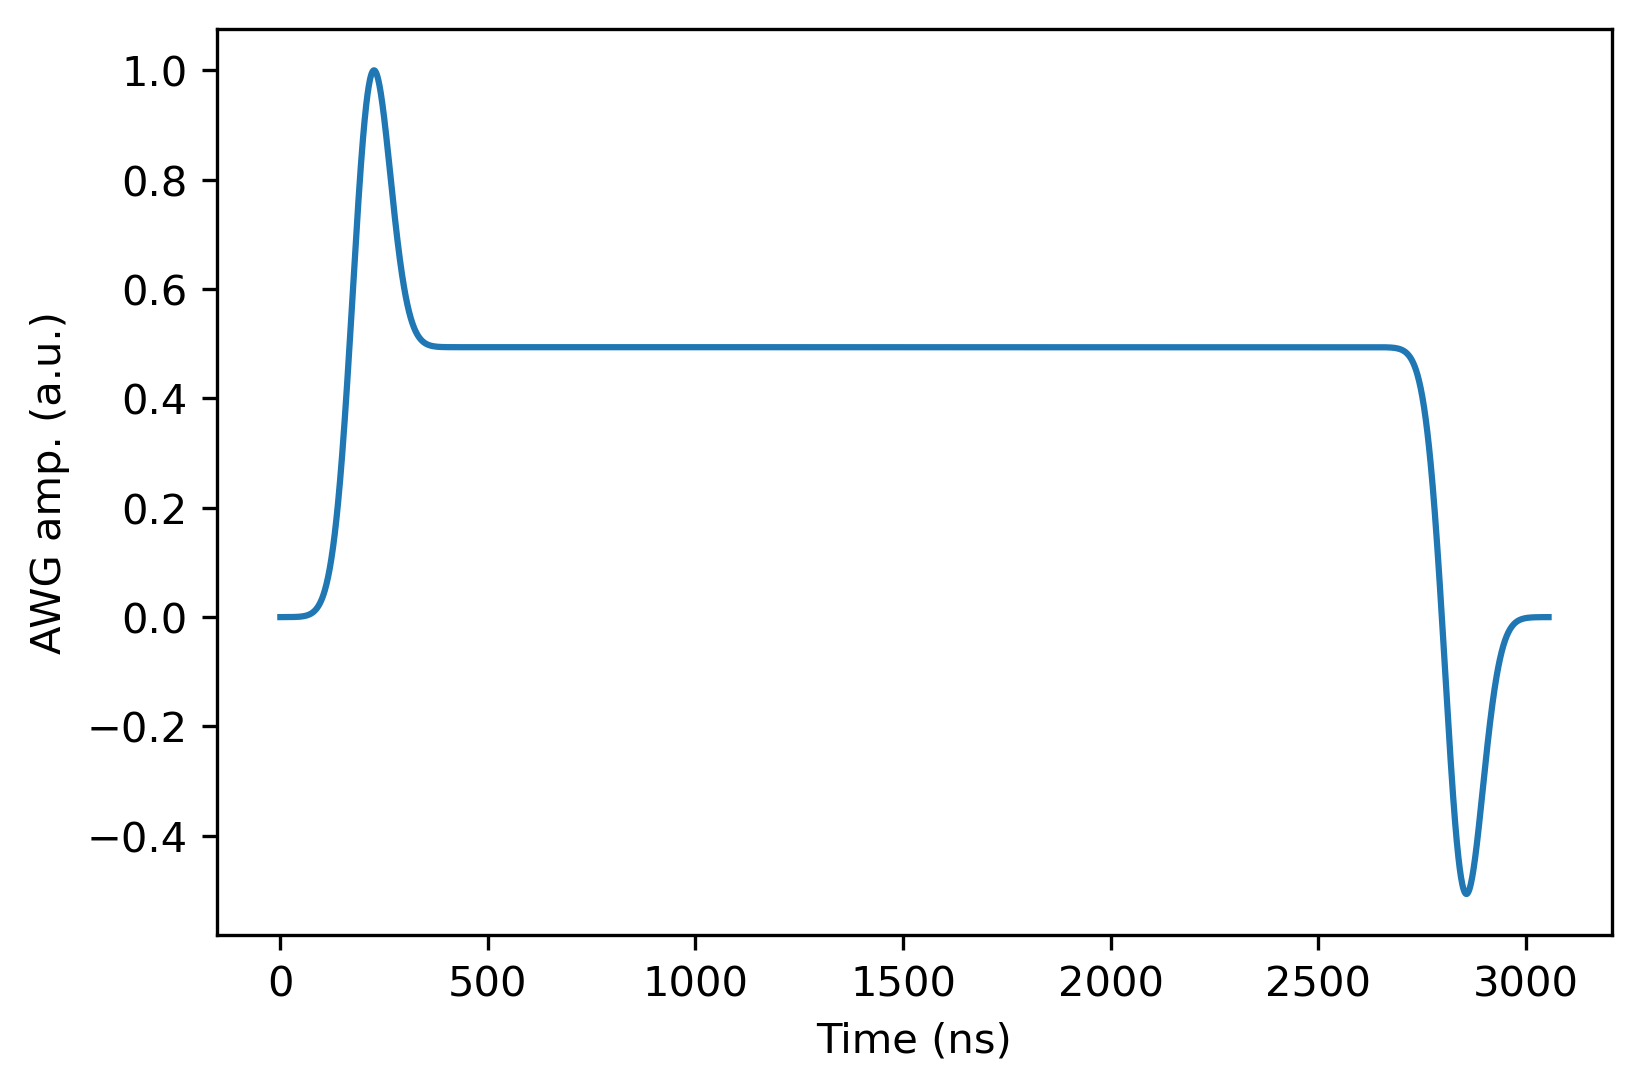

3056


In [75]:
read_params = [8.0517e9, 8400, 3.4e-6, 1e-9, 380e3]
s = optimal_rr(read_params, flat_top_amp=0.45)

plt.figure(dpi=300)
plt.plot(s)
plt.xlabel('Time (ns)')
plt.ylabel('AWG amp. (a.u.)')
plt.show()

print(len(s))

## Save Opt Pulse Shape

In [112]:
path = os.getcwd()
data_path = os.path.join(path, "../pulses/")
seq_data_file = os.path.join(data_path,
                             get_next_filename(data_path, 'readout_optimal_pulse', suffix='.h5'))
print(seq_data_file)
with File(seq_data_file, 'w') as f:
    f.create_dataset("I_wf", data=trim_pulse)

C:\_Lib\python\slab\experiments\qm_opx\jupyter_notebooks\../pulses/00012_readout_optimal_pulse.h5


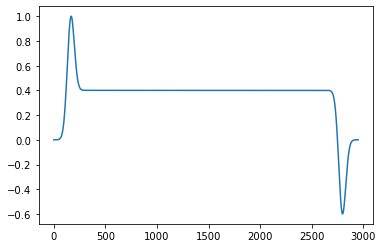

In [103]:
for i in [5]:
    opt_readout = "C:\\_Lib\\python\\slab\\experiments\\qm_opx\\pulses\\0000{}_readout_optimal_pulse.h5".format(i)
    with File(opt_readout,'r') as a:
        opt_amp = np.array(a['I_wf'])
    opt_len = len(opt_amp)
    plt.figure()
    plt.plot(opt_amp)

# Resonator spectroscopy

fits =  [-7.22626340e-07  7.37545529e-04  8.05183773e+00  4.77002479e-04]
fits =  [-2.03360016e-06  4.46103378e-04  8.05183347e+00  4.73387665e-04]


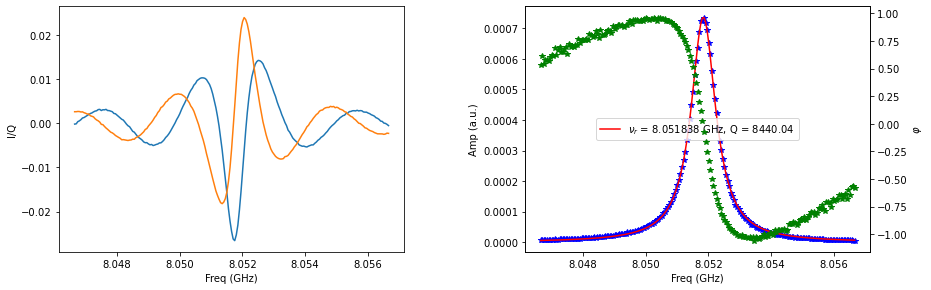

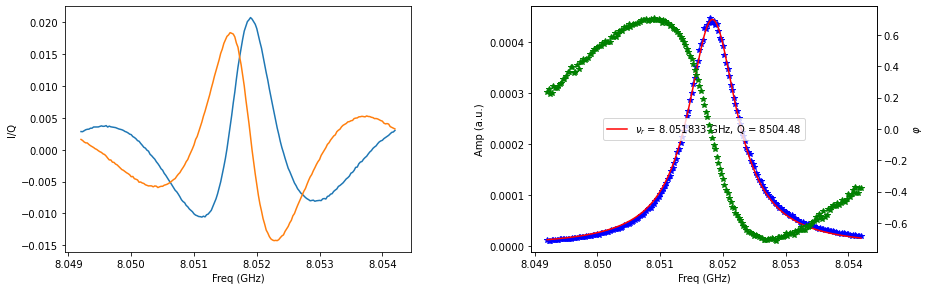

In [42]:
expt_name = 'resonator_spec'
filelist = [0, 35]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

fits =  [-1.25324606e-06  8.62685110e-05  8.05184589e+00  4.76398077e-04]
fits =  [-2.42234827e-09  8.75949477e-07  8.05184960e+00  4.58877307e-04]
fits =  [-8.45579797e-11  9.15912119e-07  8.05185353e+00  4.79274176e-04]


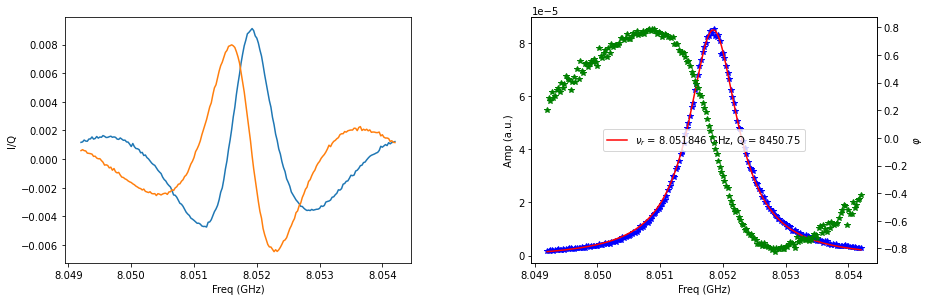

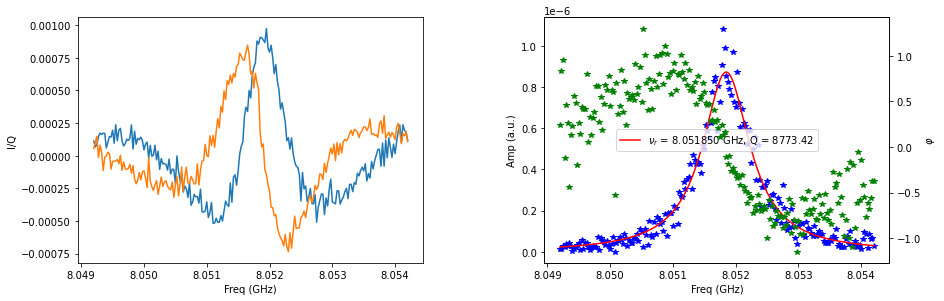

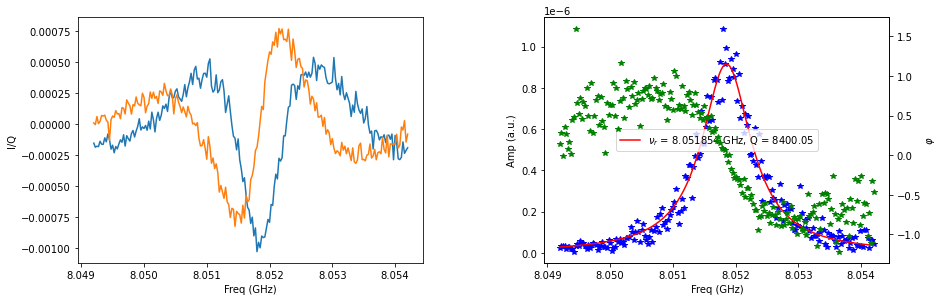

In [44]:
expt_name = 'resonator_spec_opt'
filelist = [0, 1, 2]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

(201, 26)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


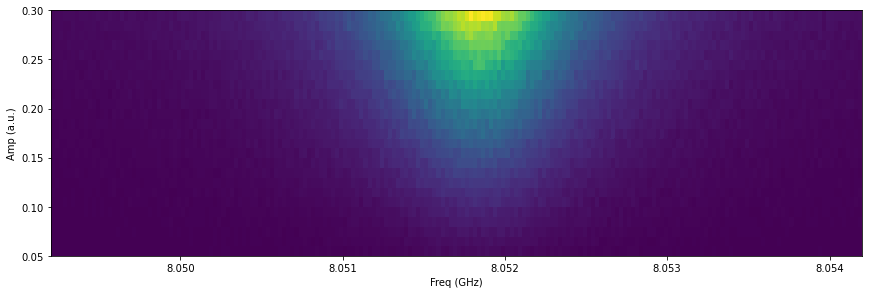

(41, 13)


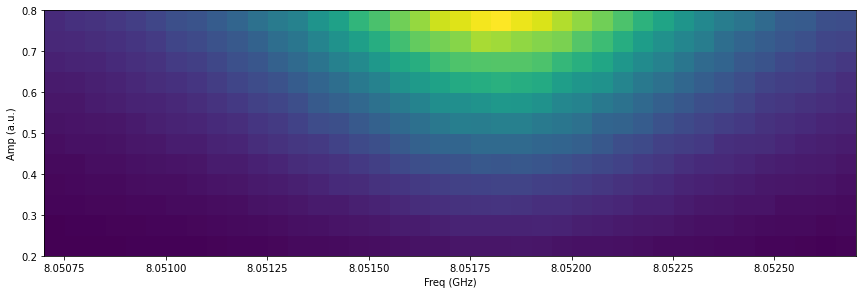

(41, 13)


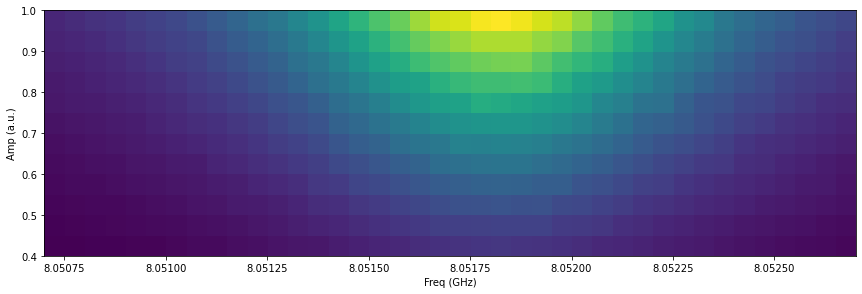

In [63]:
expt_name = 'resonator_spec_opt_power'
filelist = [1, 2, 3]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        y = array(a['amps'])
        a.close()
                
    print(np.shape(I))
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    amps = np.transpose(Q**2 + I**2)
#     ph = np.arctan2(np.array(Q), np.array(I))
#     ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
#     m = (ph[-1]-ph[0])/(x[-1] - x[0])
#     ph = ph - m*x*0.95
#     ph = ph -np.mean(ph)
    axs.pcolormesh(x, y, amps)
#     p = fitlor(x, amps, showfit=False)
#     q = p[2]/(2*p[3])
#     axs.plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
#     print ("fits = ", p)
#     ax2  = axs[1].twinx()
#     ax2.plot(x, ph, 'g*')
    axs.set_xlabel('Freq (GHz)')
    axs.set_ylabel('Amp (a.u.)')
#     axs.set_xlim(8.051, 8.053)
#     ax2.set_ylabel('$\\varphi$')
#     axs.legend(loc='center')
    plt.show()

# Resonator Chi

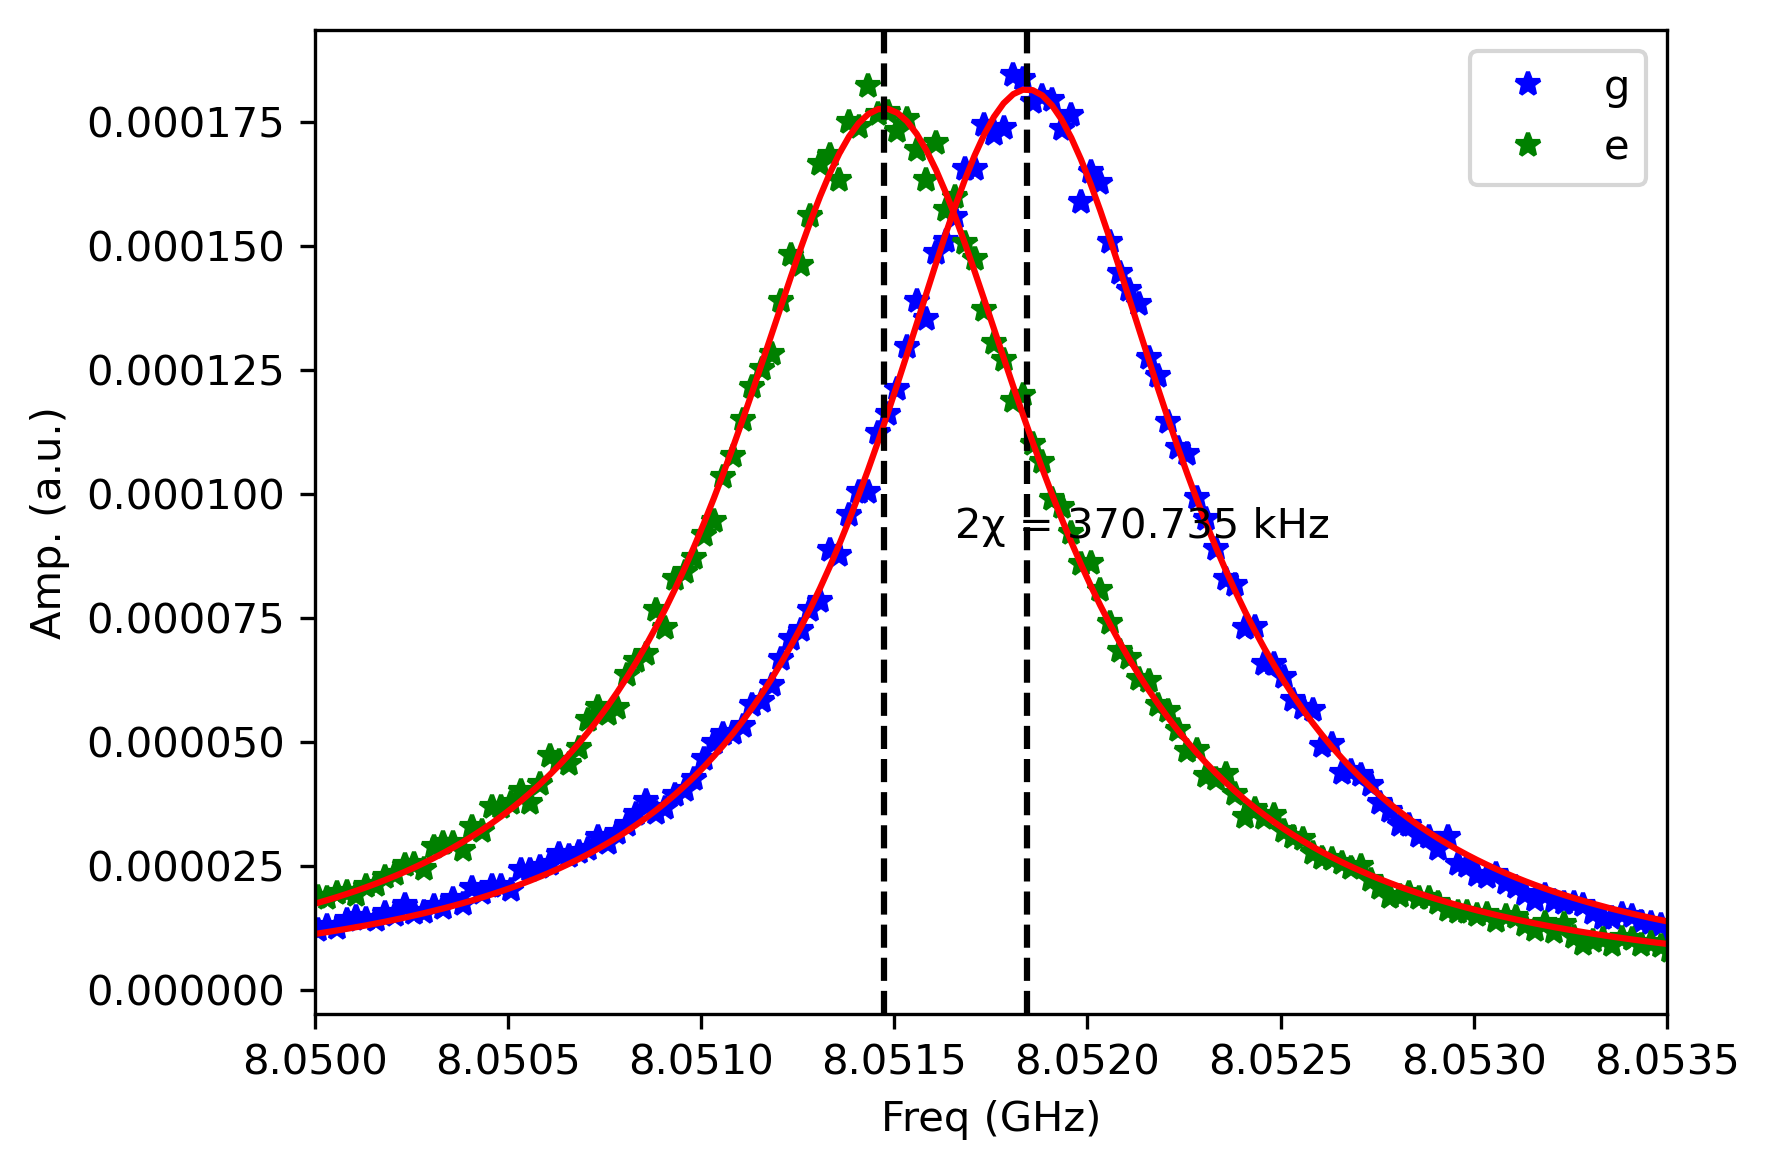

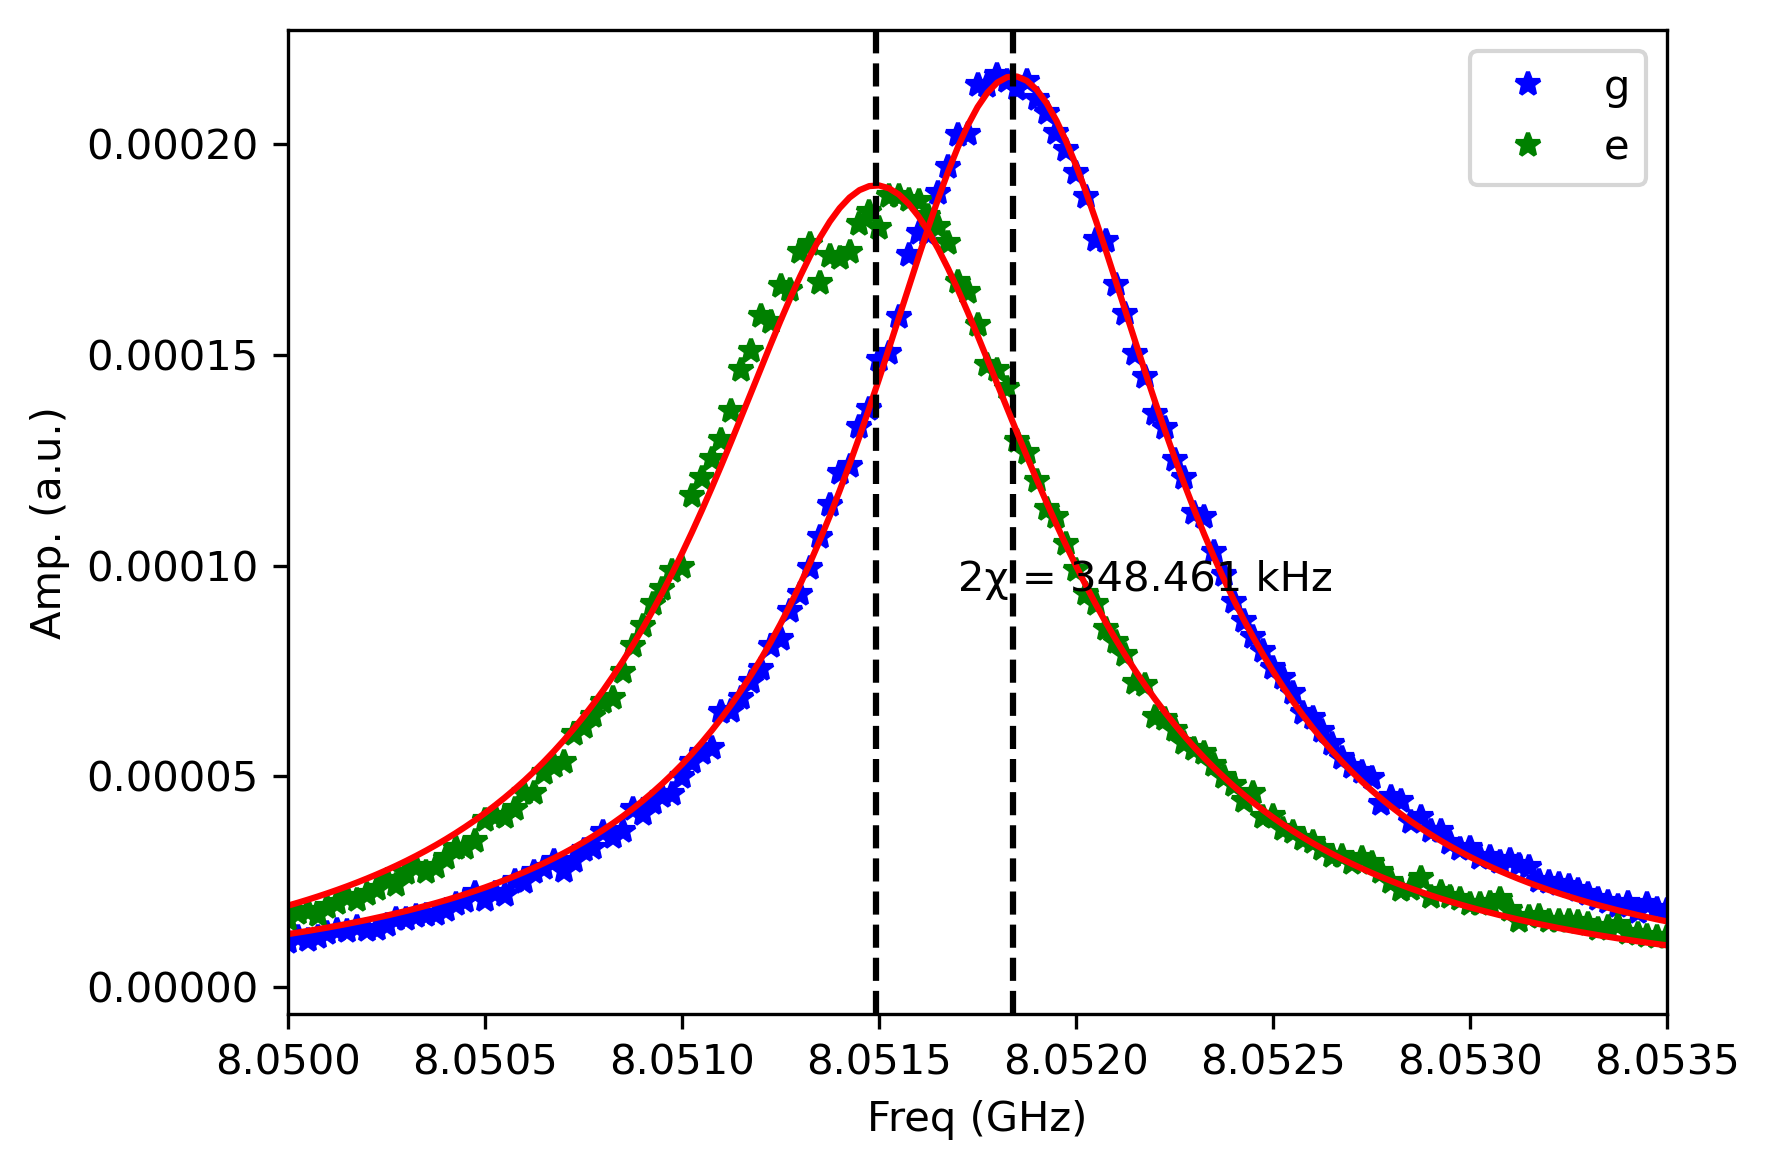

In [119]:
expt_name = 'resonator_chi'
filelist = [2,  17]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='g')
    ax1.plot(f, amps_e, 'g*', label='e')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
    ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
    ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
    plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [6]:
250*10*5000*5000000*1e-9/3600

17.361111111111114

# Cavity calibration

## Square pulse, 8μs

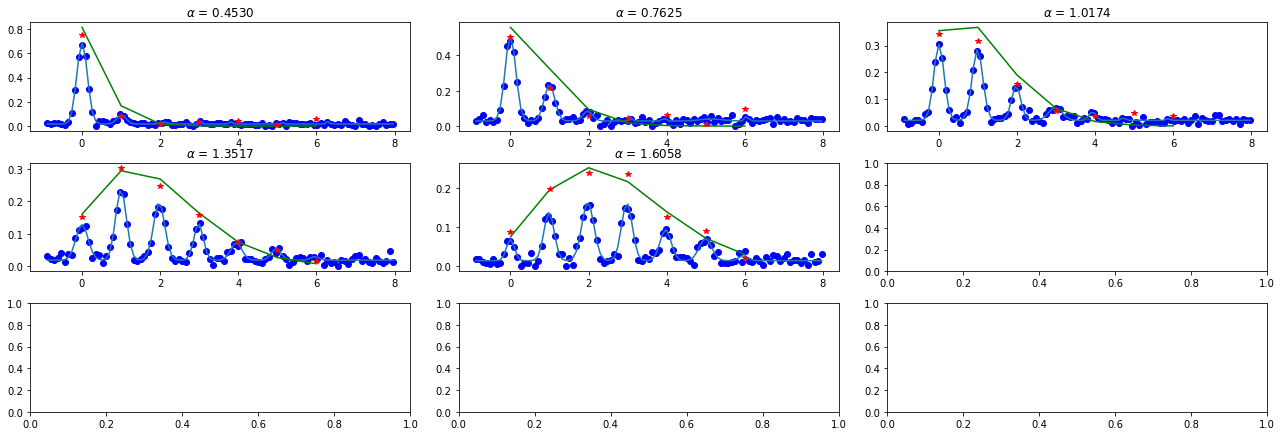

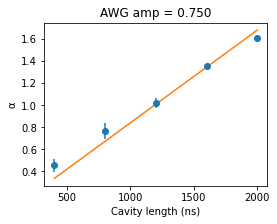

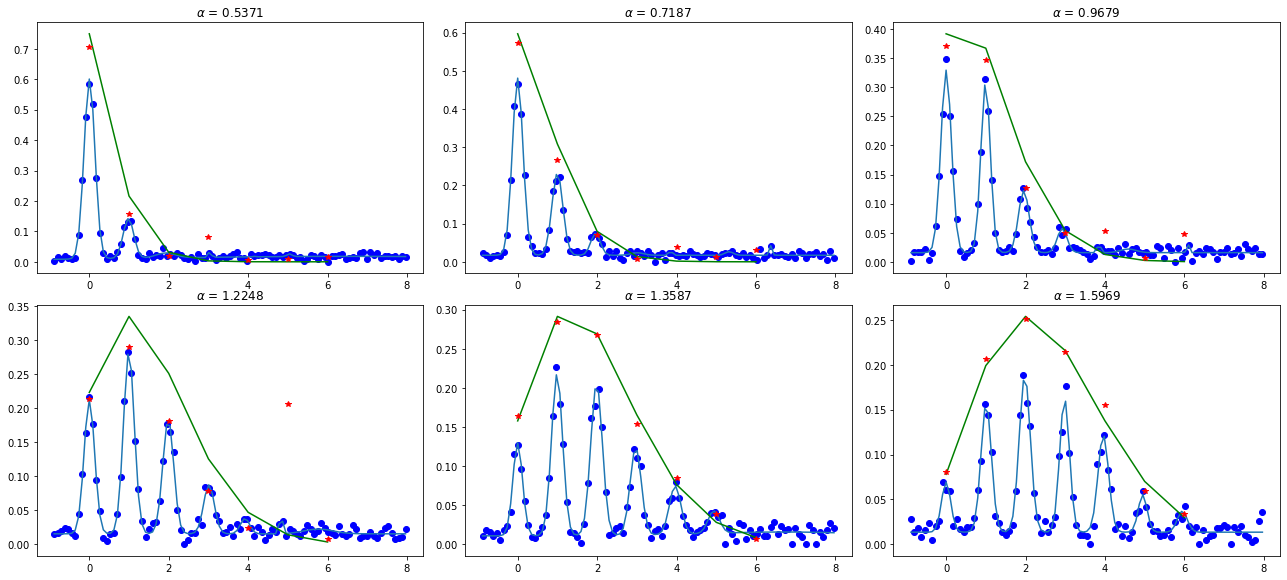

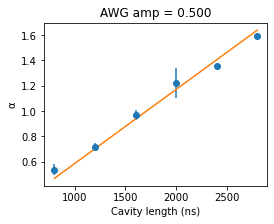

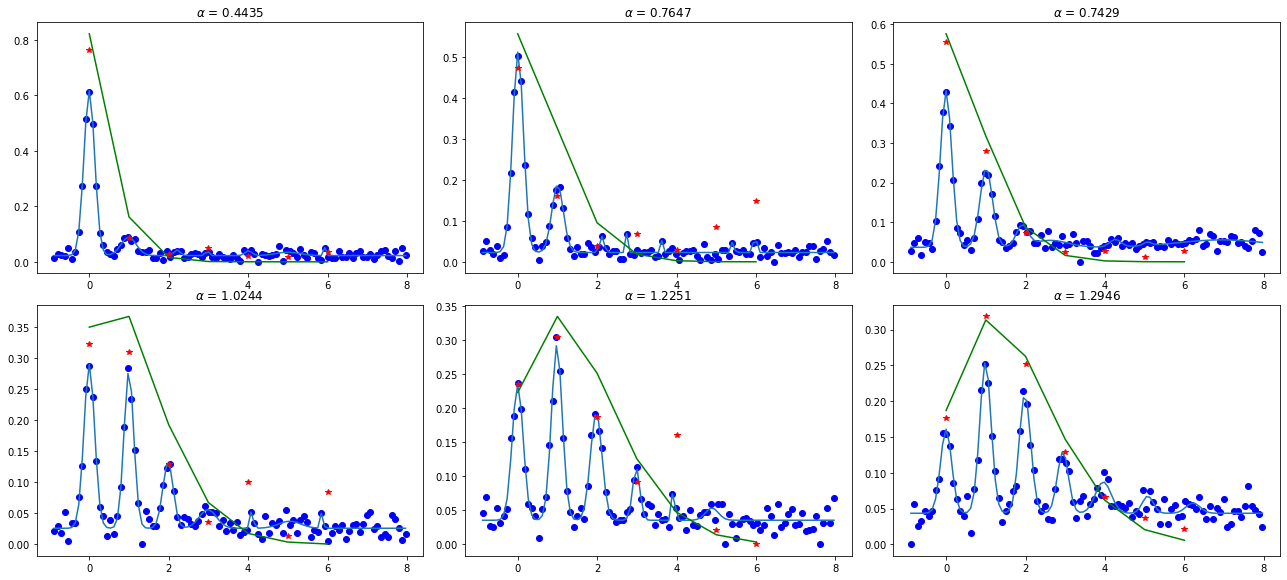

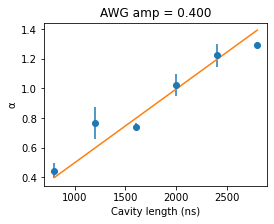

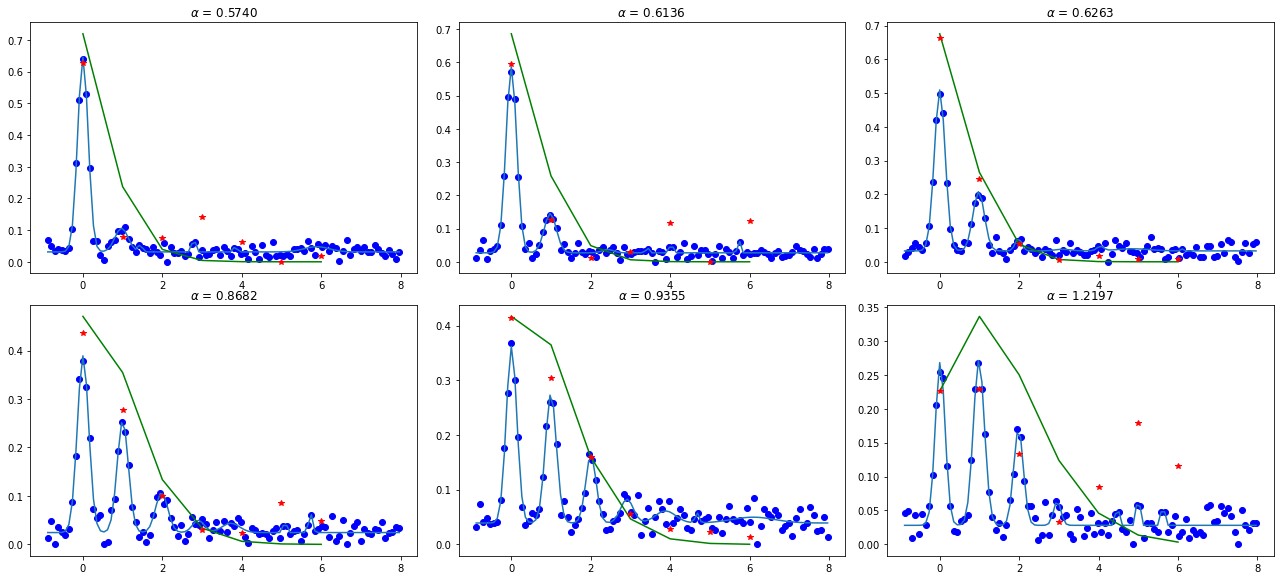

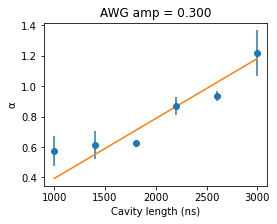

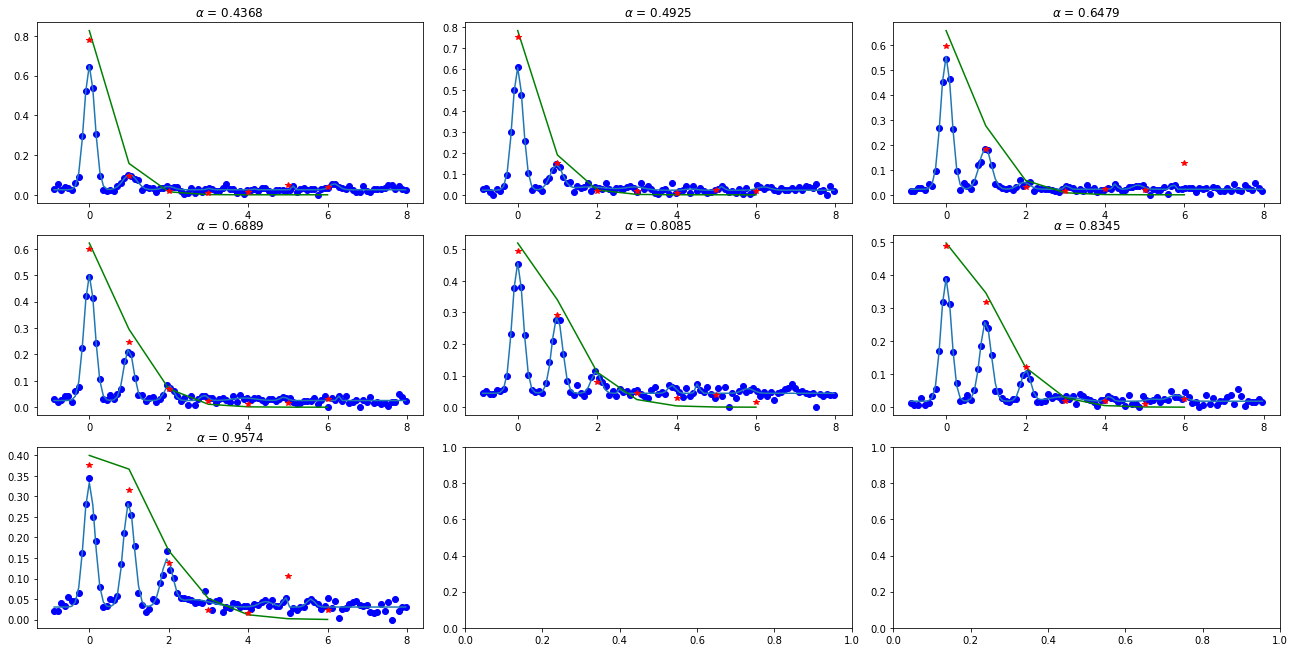

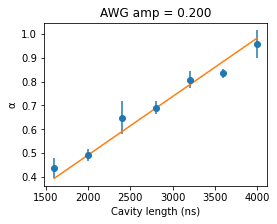

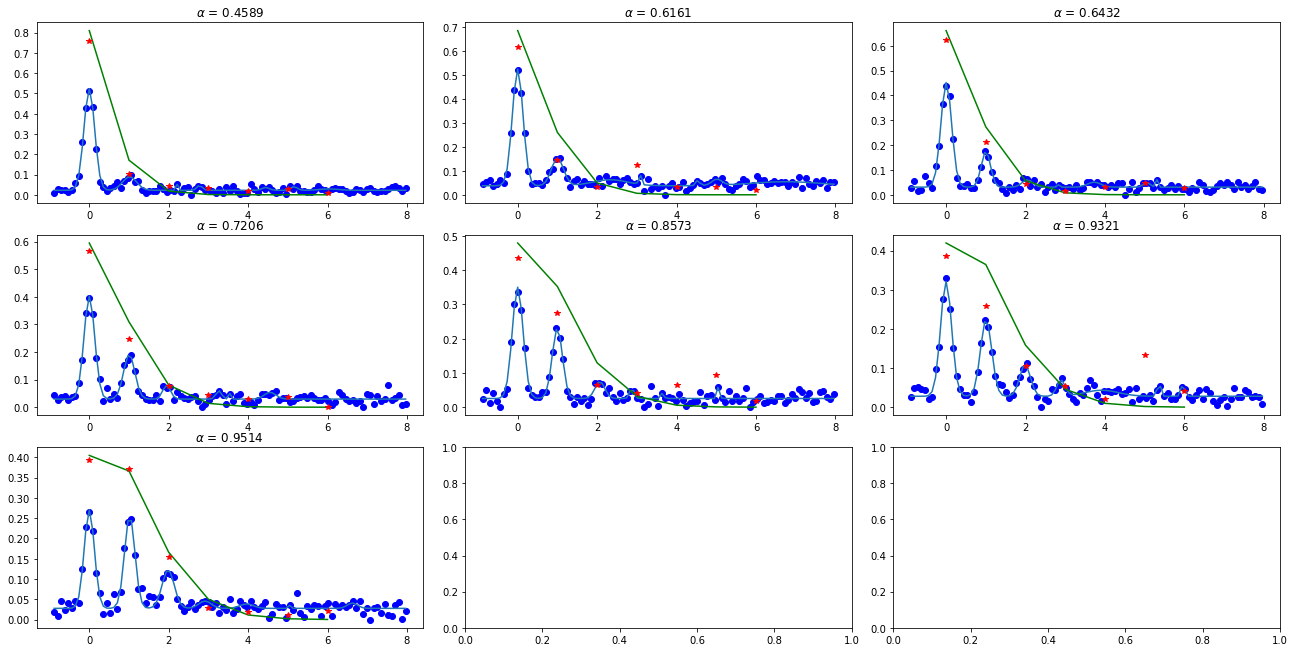

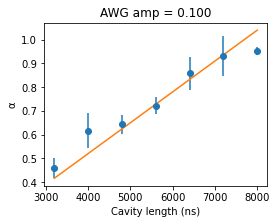

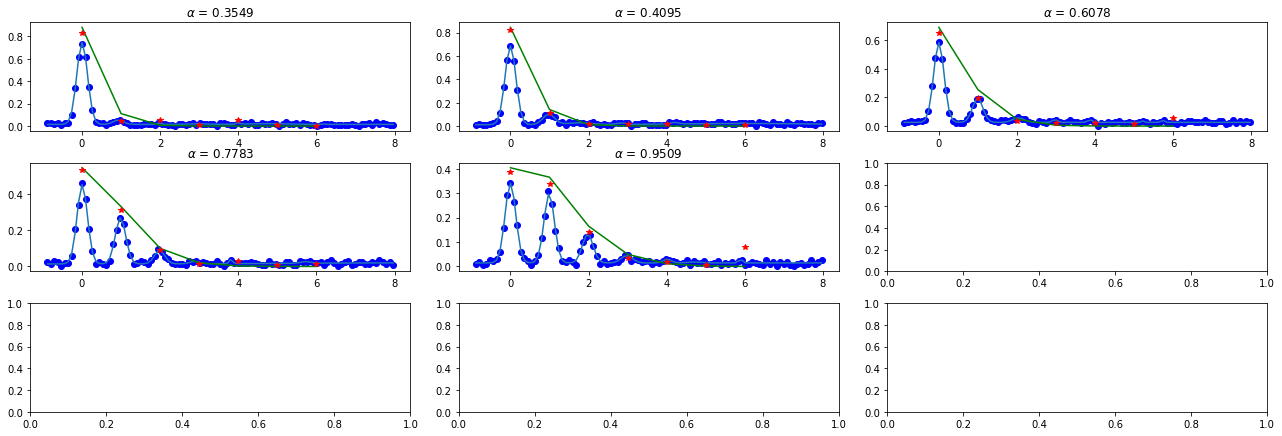

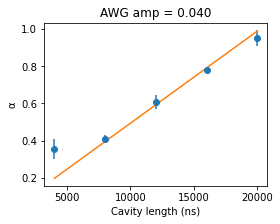

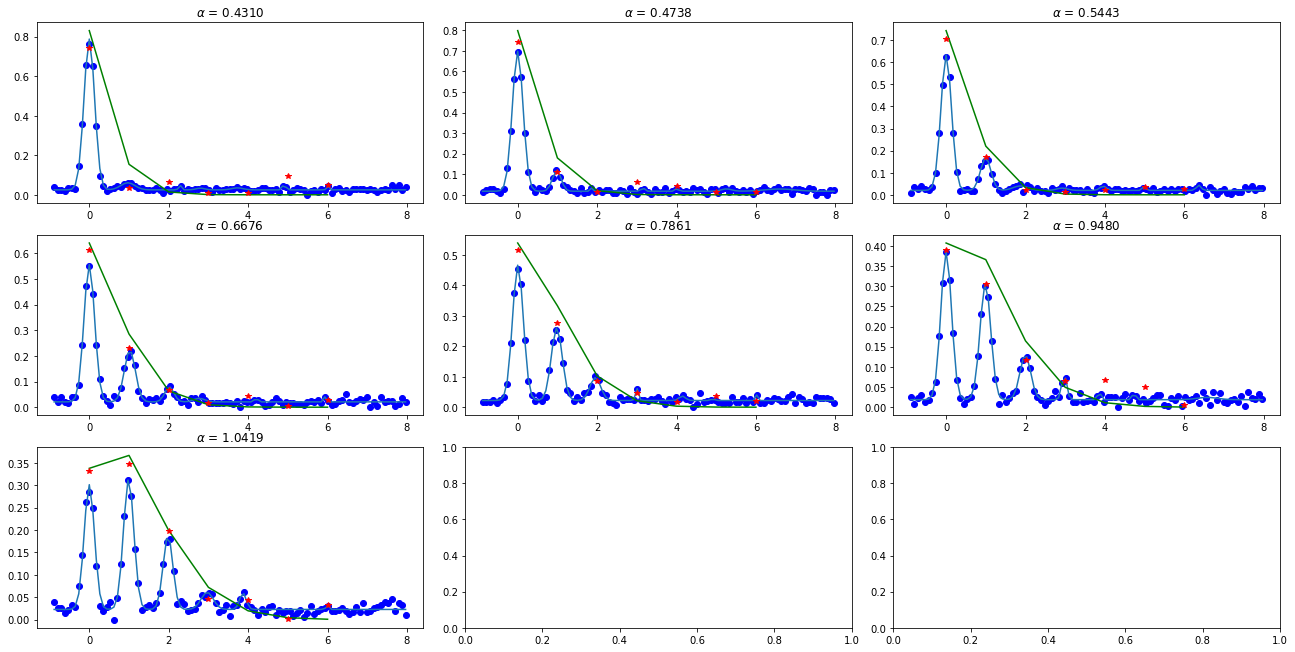

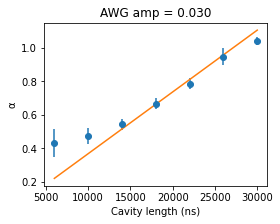

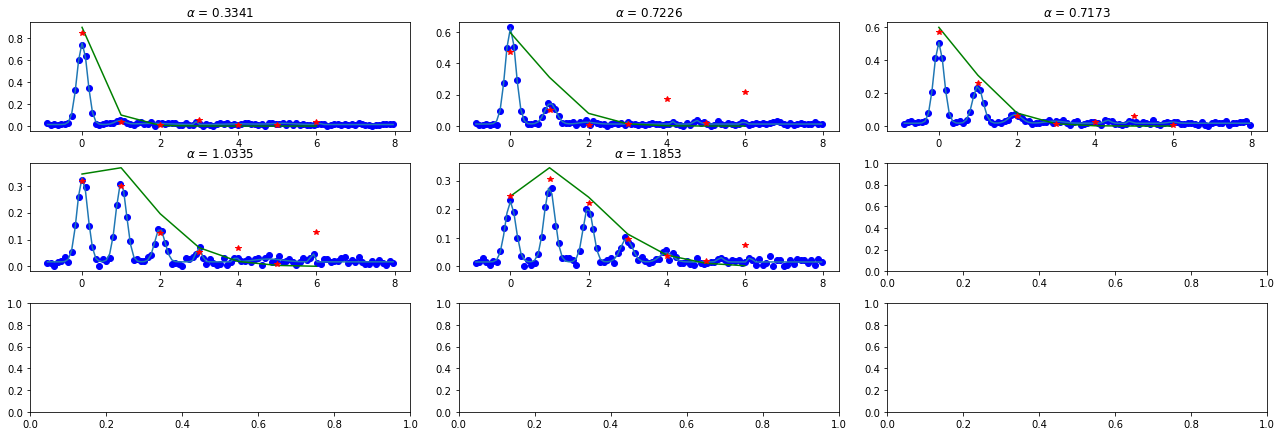

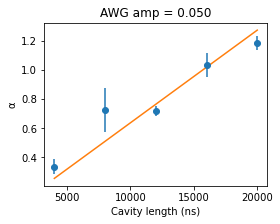

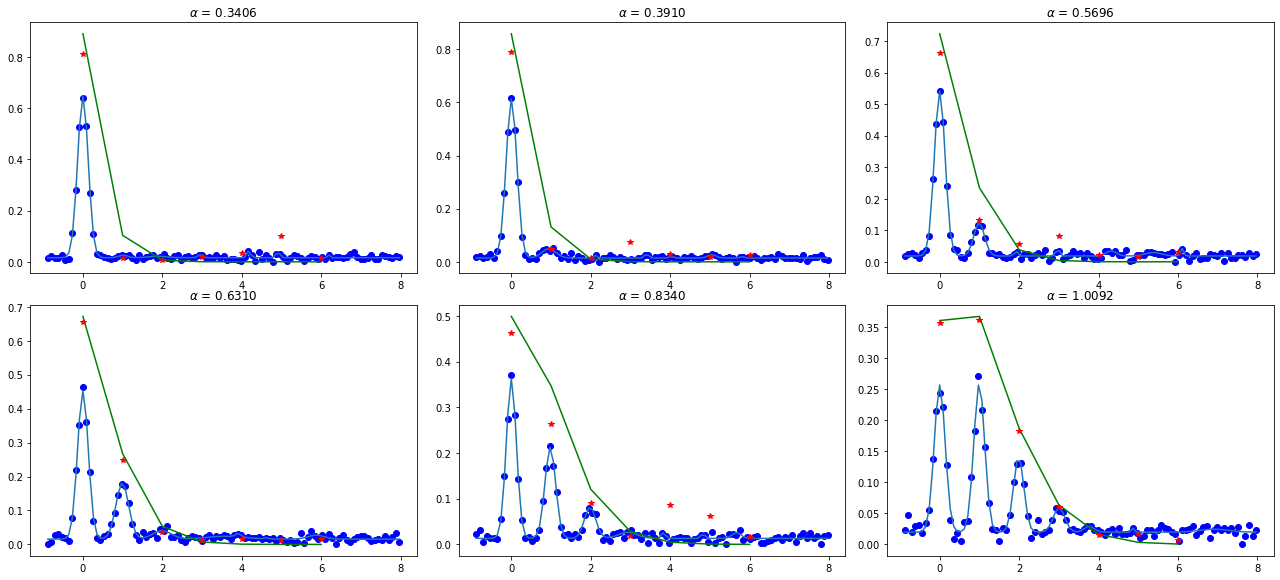

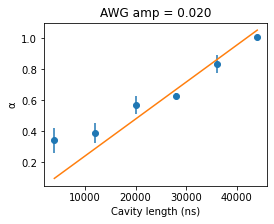

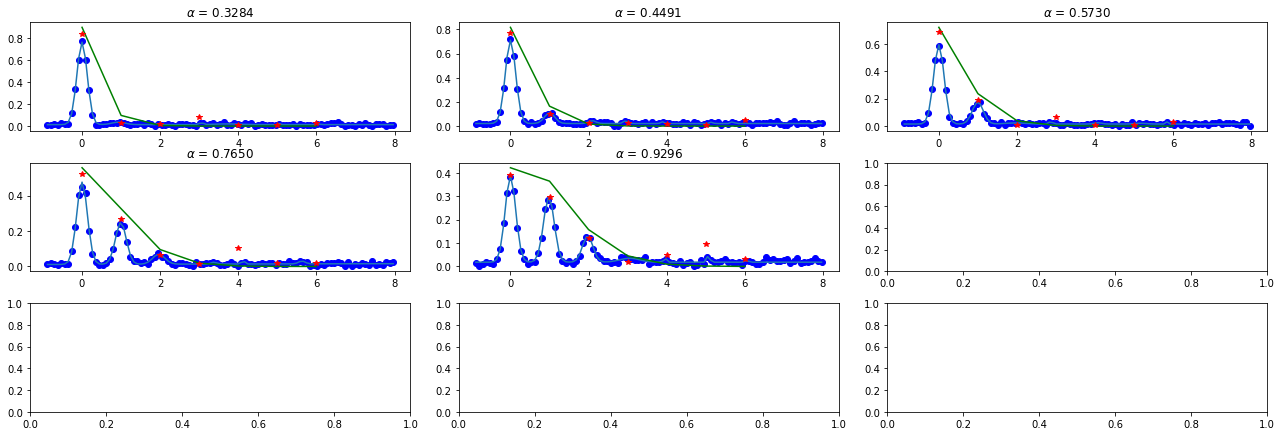

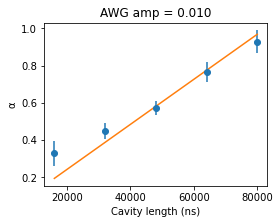

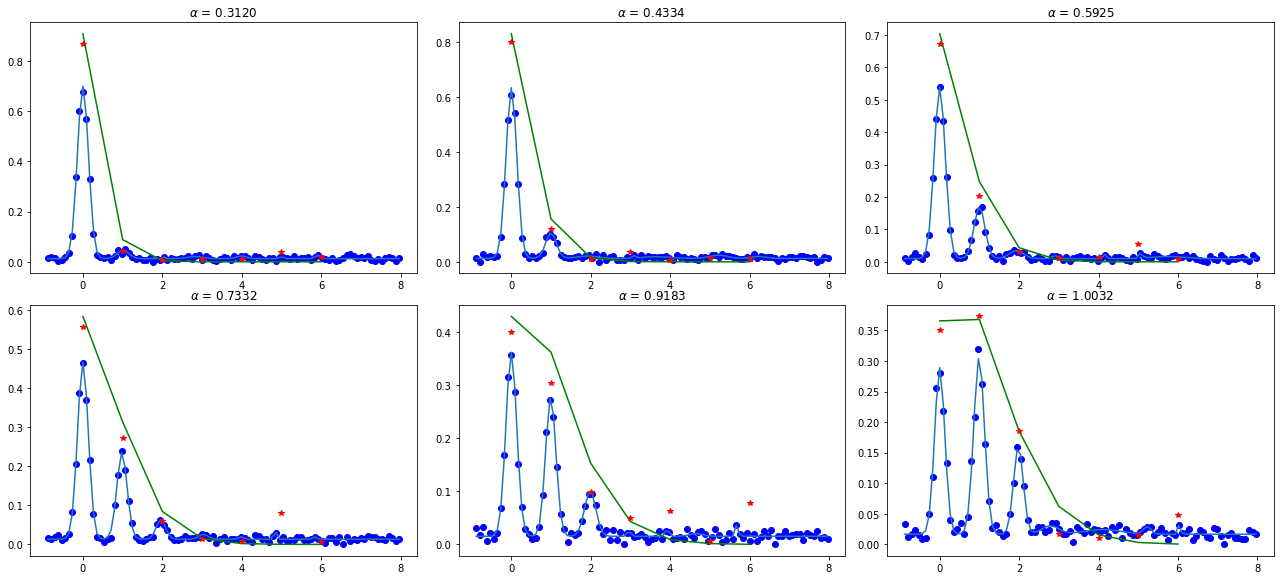

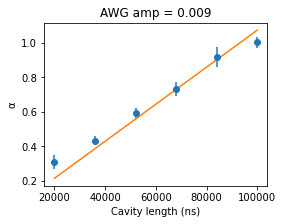

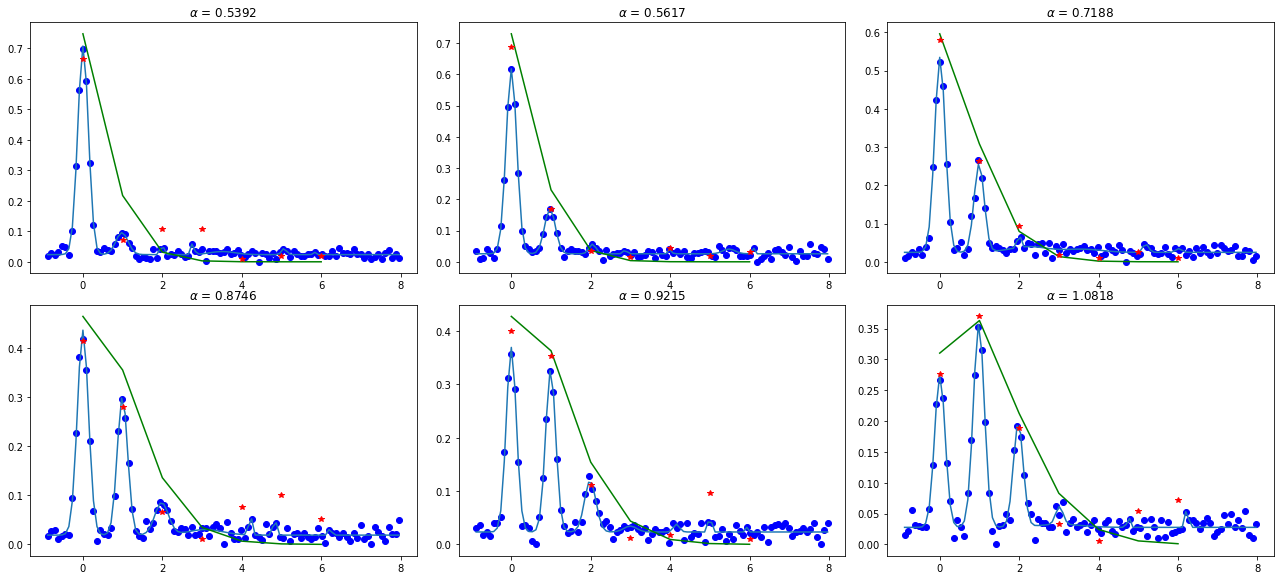

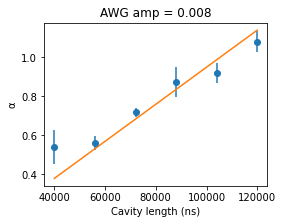

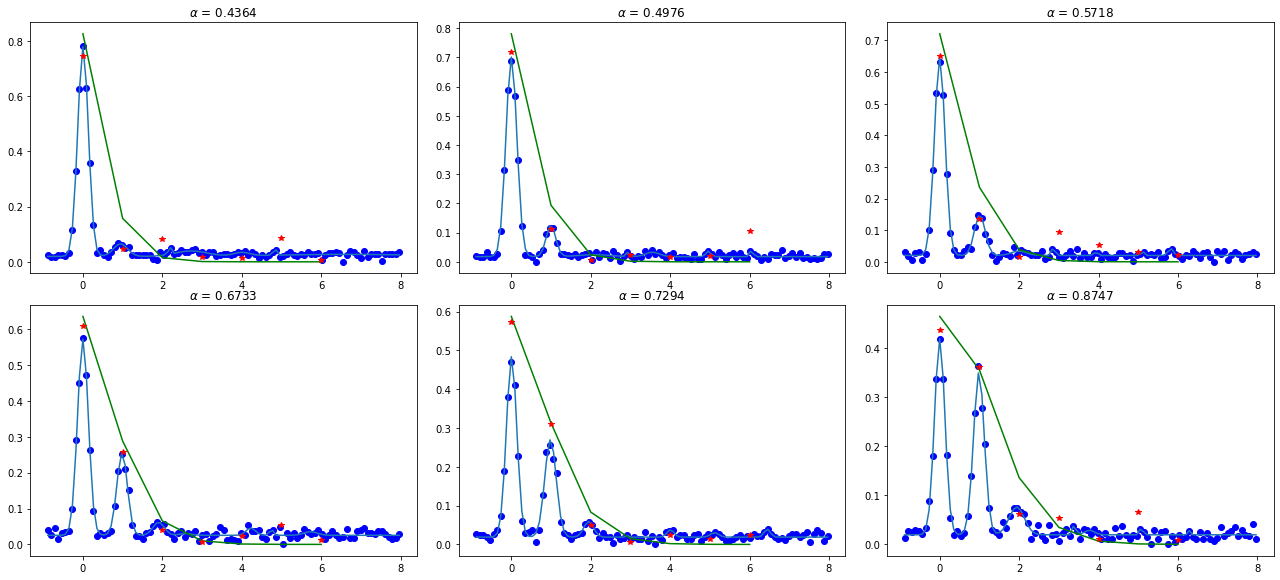

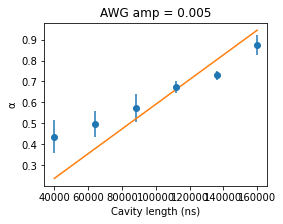

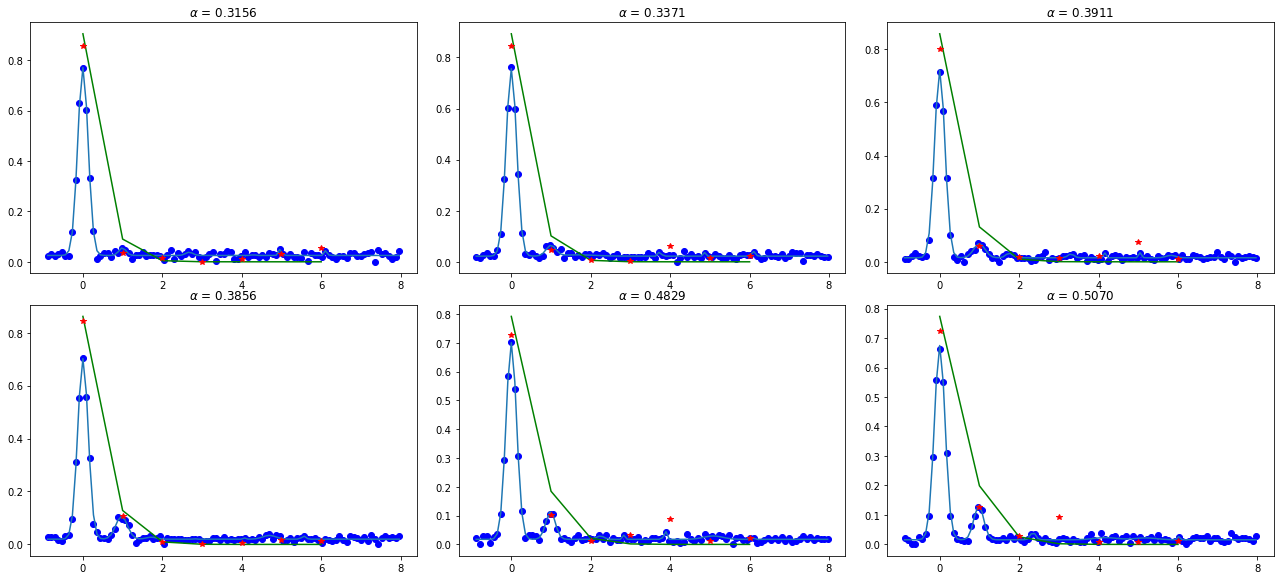

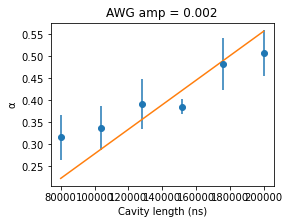

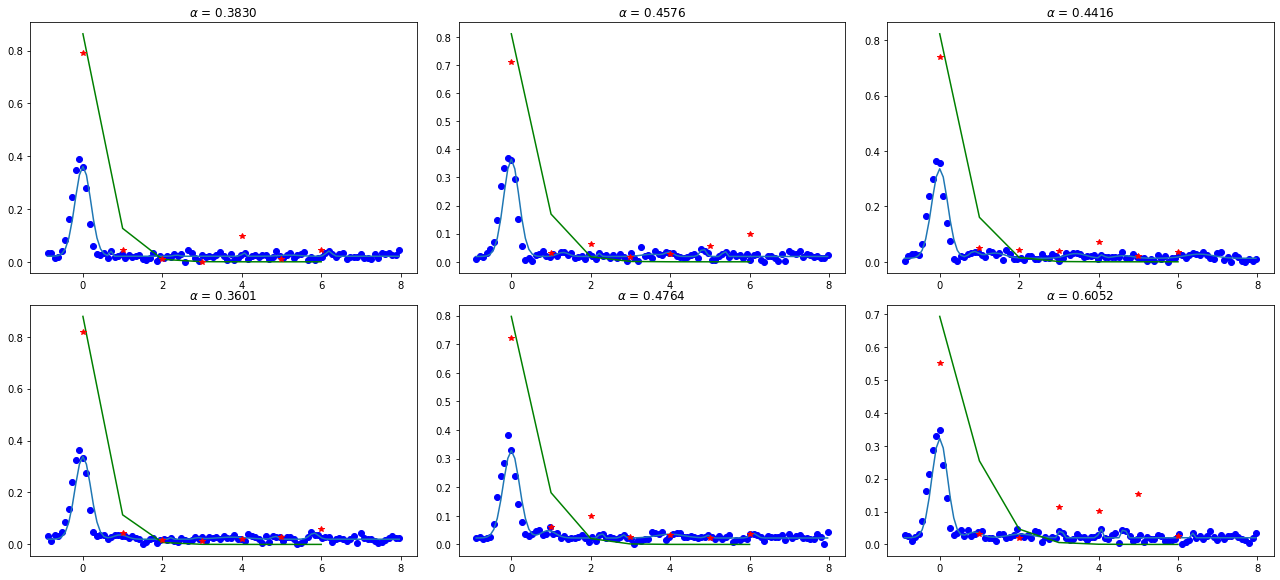

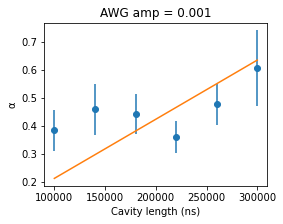

In [358]:
expt_name = 'alpha_cal'
filelist = [4, 17, 6, 7, 8, 10, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24]
amps_c = []
xis_vs_amps = []

twochi = -1.13e6
N = 7 # max photon number to fit to

for ii, i in enumerate(filelist):
    filename = "S:\\_Data\\210326 - QM_OPX\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"


    with File(filename,'r') as a:

        I = np.array(a['I'])
        Q = np.array(a['res'])

        amp = np.array(a['amp'])
        times = 4*np.array(a['times'])

        freqs = np.array(a['freq'])
        a.close()

    amps_c.append(amp)

    fig, axs = plt.subplots(nrows=len(times)//3+len(times)%3, ncols=3, figsize=(18, 4*len(times)//3))
    fig.tight_layout()

    alpha = []
    alpha_err = []
    for jj in range(len(times)):
        y = Q[jj]
        y = (y-np.min(y))
#         y = y/np.max(y)

        t = times[jj]
        x = freqs/twochi

        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0
        ax = axs[jj//3, jj%3]
        ax.plot(x, y, 'bo')

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
        
        ax.plot(x, gaussfuncsum_with_baseline(x, *p1))
        
        peak_val, freq_val = fitamp(p1)
        
        peak_val = peak_val/np.sum(peak_val)

        a, a_err = fitcoherentstate(peak_val)
        ax.plot(coherent_state(np.arange(len(peak_val)), a), 'g')

        ax.plot(peak_val,'r*')
#         ax.plot(peak_val_test,'y*')
        
        ax.set_title(r'$\alpha$ = %.4f'%a)
        alpha.append(a)
        alpha_err.append(a_err)
    plt.show()
    if i==4:
        h = 0
    elif i==5:
        h = 1
    plt.figure(figsize=(4, 3))
    plt.errorbar(x=times[h:], y=alpha[h:], yerr=alpha_err[h:], fmt='o')
    popt, pcov = curve_fit(proportional, times[h:], alpha[h:])
    xis_vs_amps.append(popt[0])
    plt.plot(times[h:], proportional(times[h:], popt))
    plt.title('AWG amp = %.3f'%amp)
    plt.xlabel('Cavity length (ns)')
    plt.ylabel('α')
    plt.show()

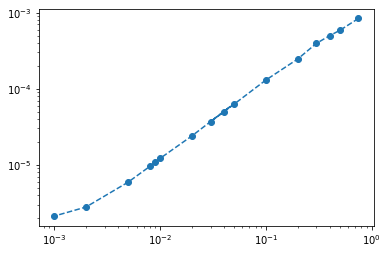

In [359]:
plt.loglog(amps_c, xis_vs_amps, 'o--')

## Export

In [360]:
d = {'Amps': amps_c, 'Omegas': xis_vs_amps}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps    Omegas
0    0.75  0.000839
1     0.5  0.000586
2     0.4  0.000498
3     0.3  0.000394
4     0.2  0.000246
5     0.1  0.000130
8    0.05  0.000064
6    0.04  0.000049
7    0.03  0.000037
9    0.02  0.000024
10   0.01  0.000012
11  0.009  0.000011
12  0.008  0.000010
13  0.005  0.000006
14  0.002  0.000003
15  0.001  0.000002

In [361]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'cavity_square'
file_number = 0

pulse_type = 'square'
date = '2021_04_01'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=xis_vs_amps)
    hf.create_dataset('amps', data=amps_c)
    hf.create_dataset('date', data=date)

print("done")

done


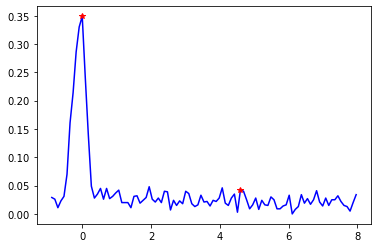

In [362]:
from scipy.signal import find_peaks
plt.plot(x, y, 'b')

p = np.mean(y)

peaks, _ = find_peaks(y, prominence=p)
plt.plot(x[peaks], y[peaks], 'r*')

# Qubit Square calibration

(16, 51)


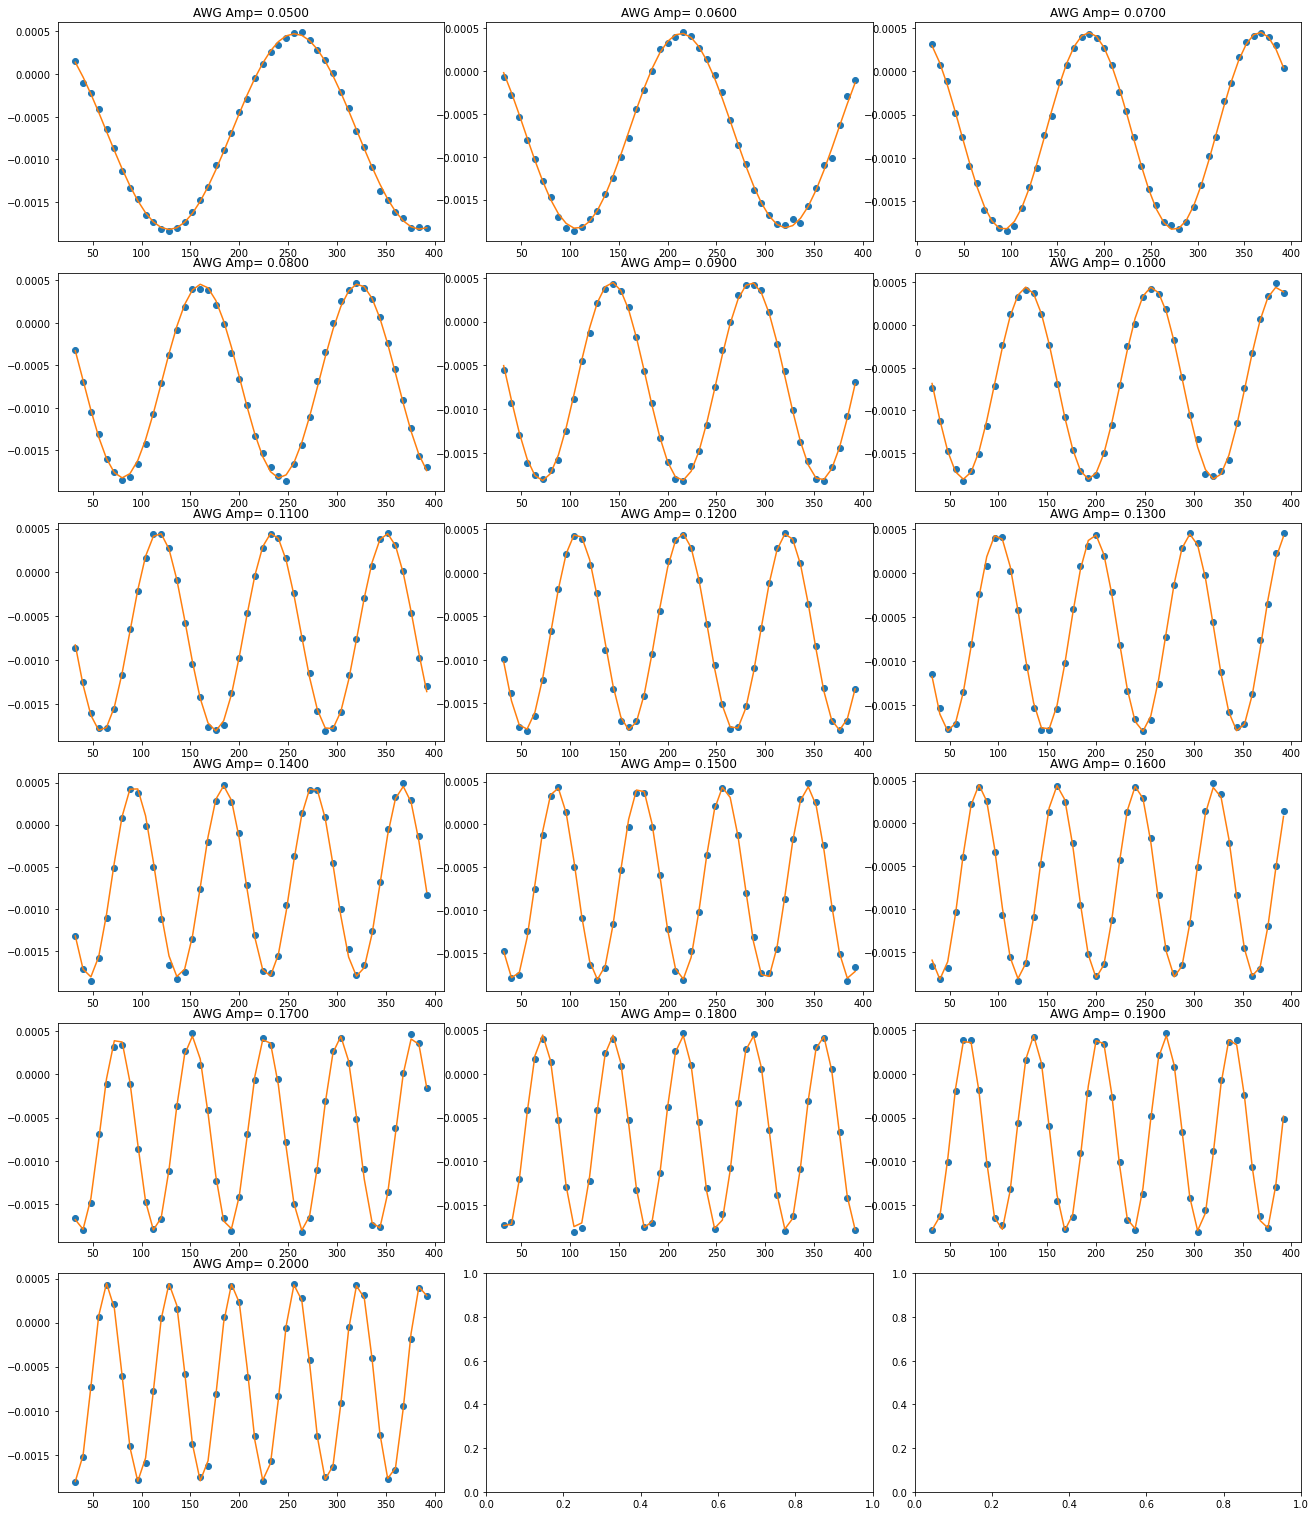

(21, 51)


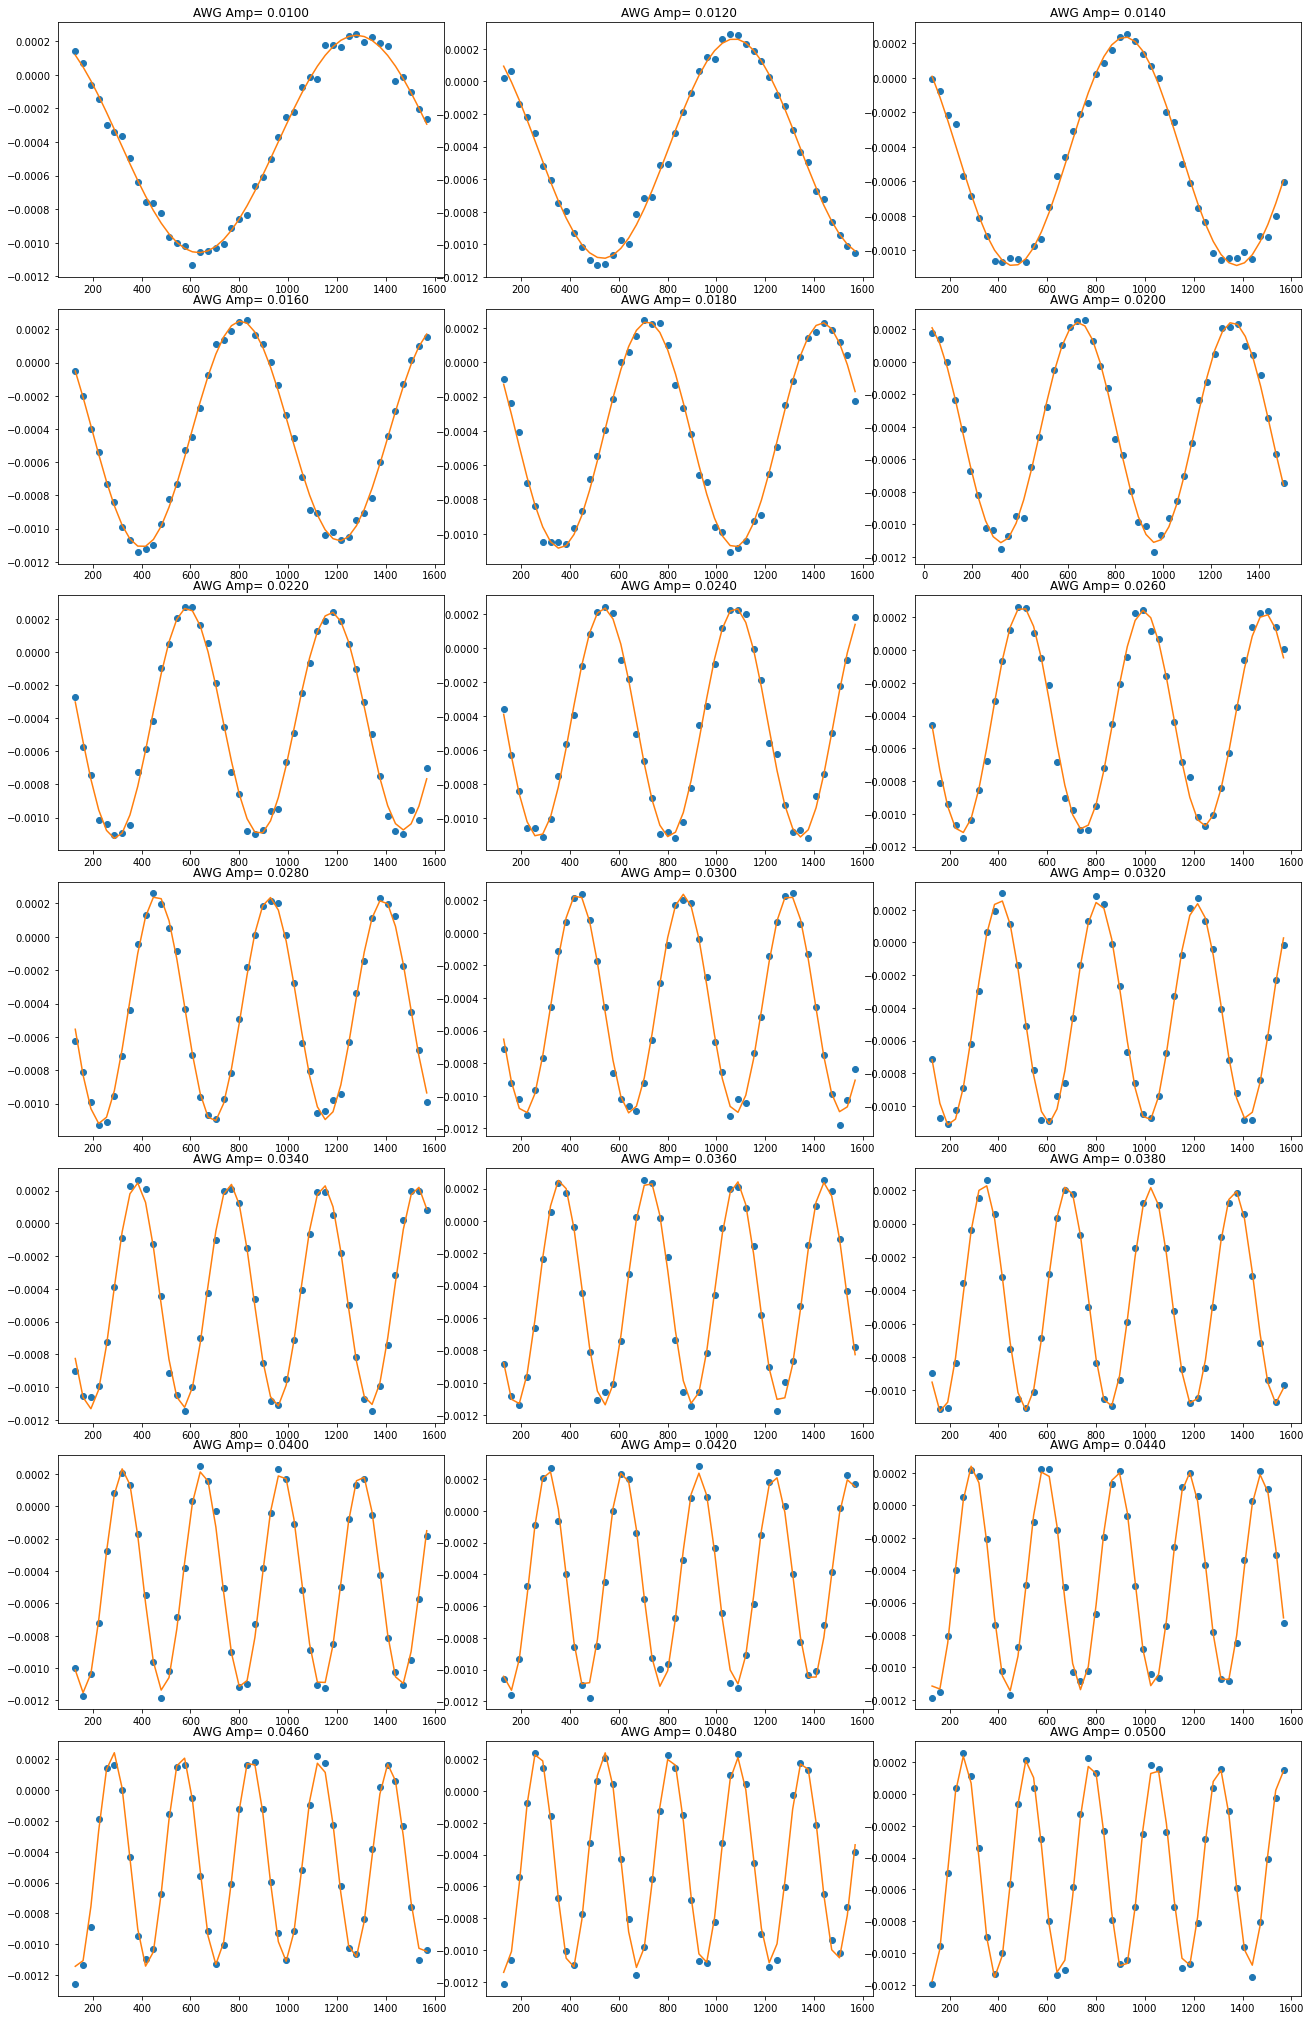

(19, 101)


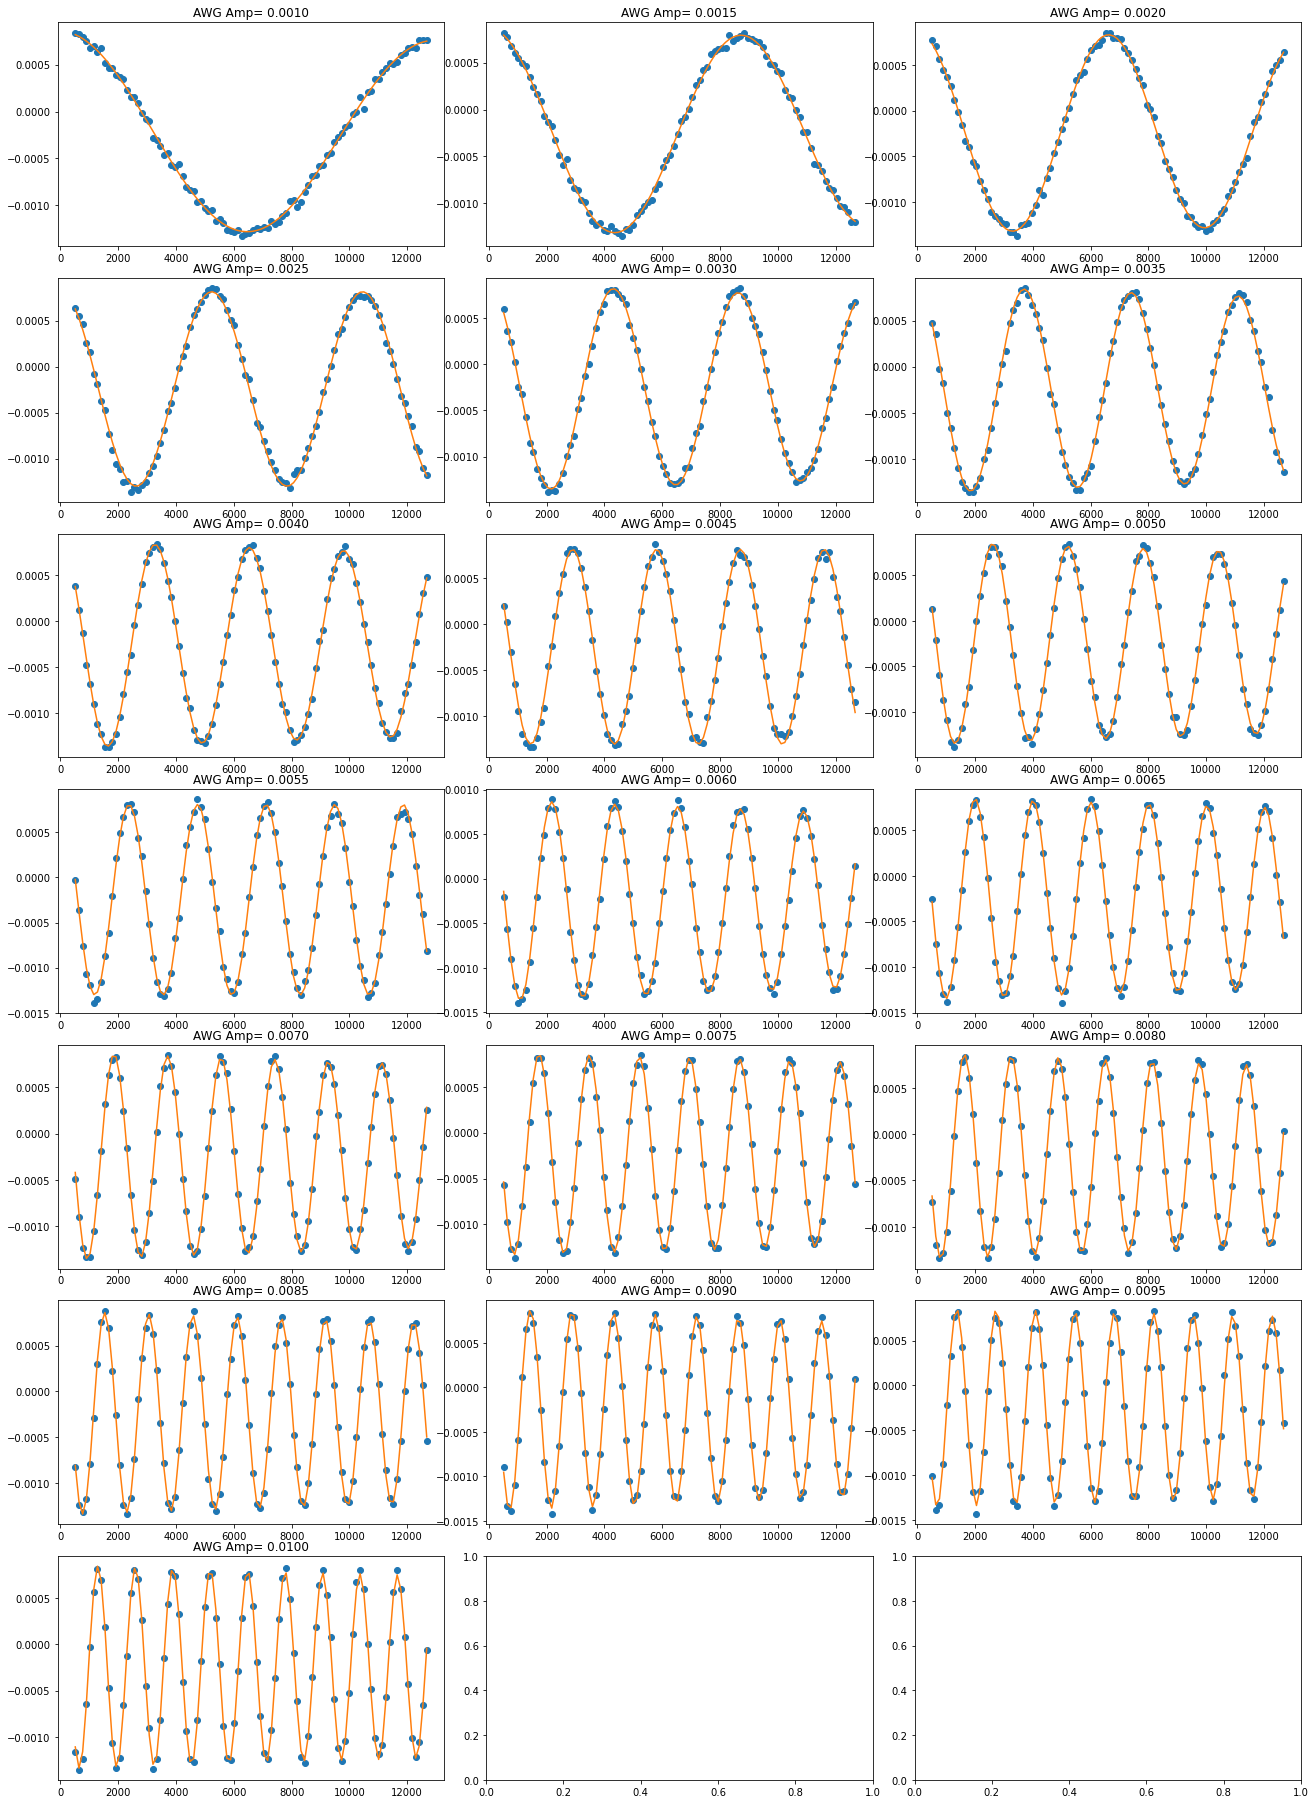

(19, 101)


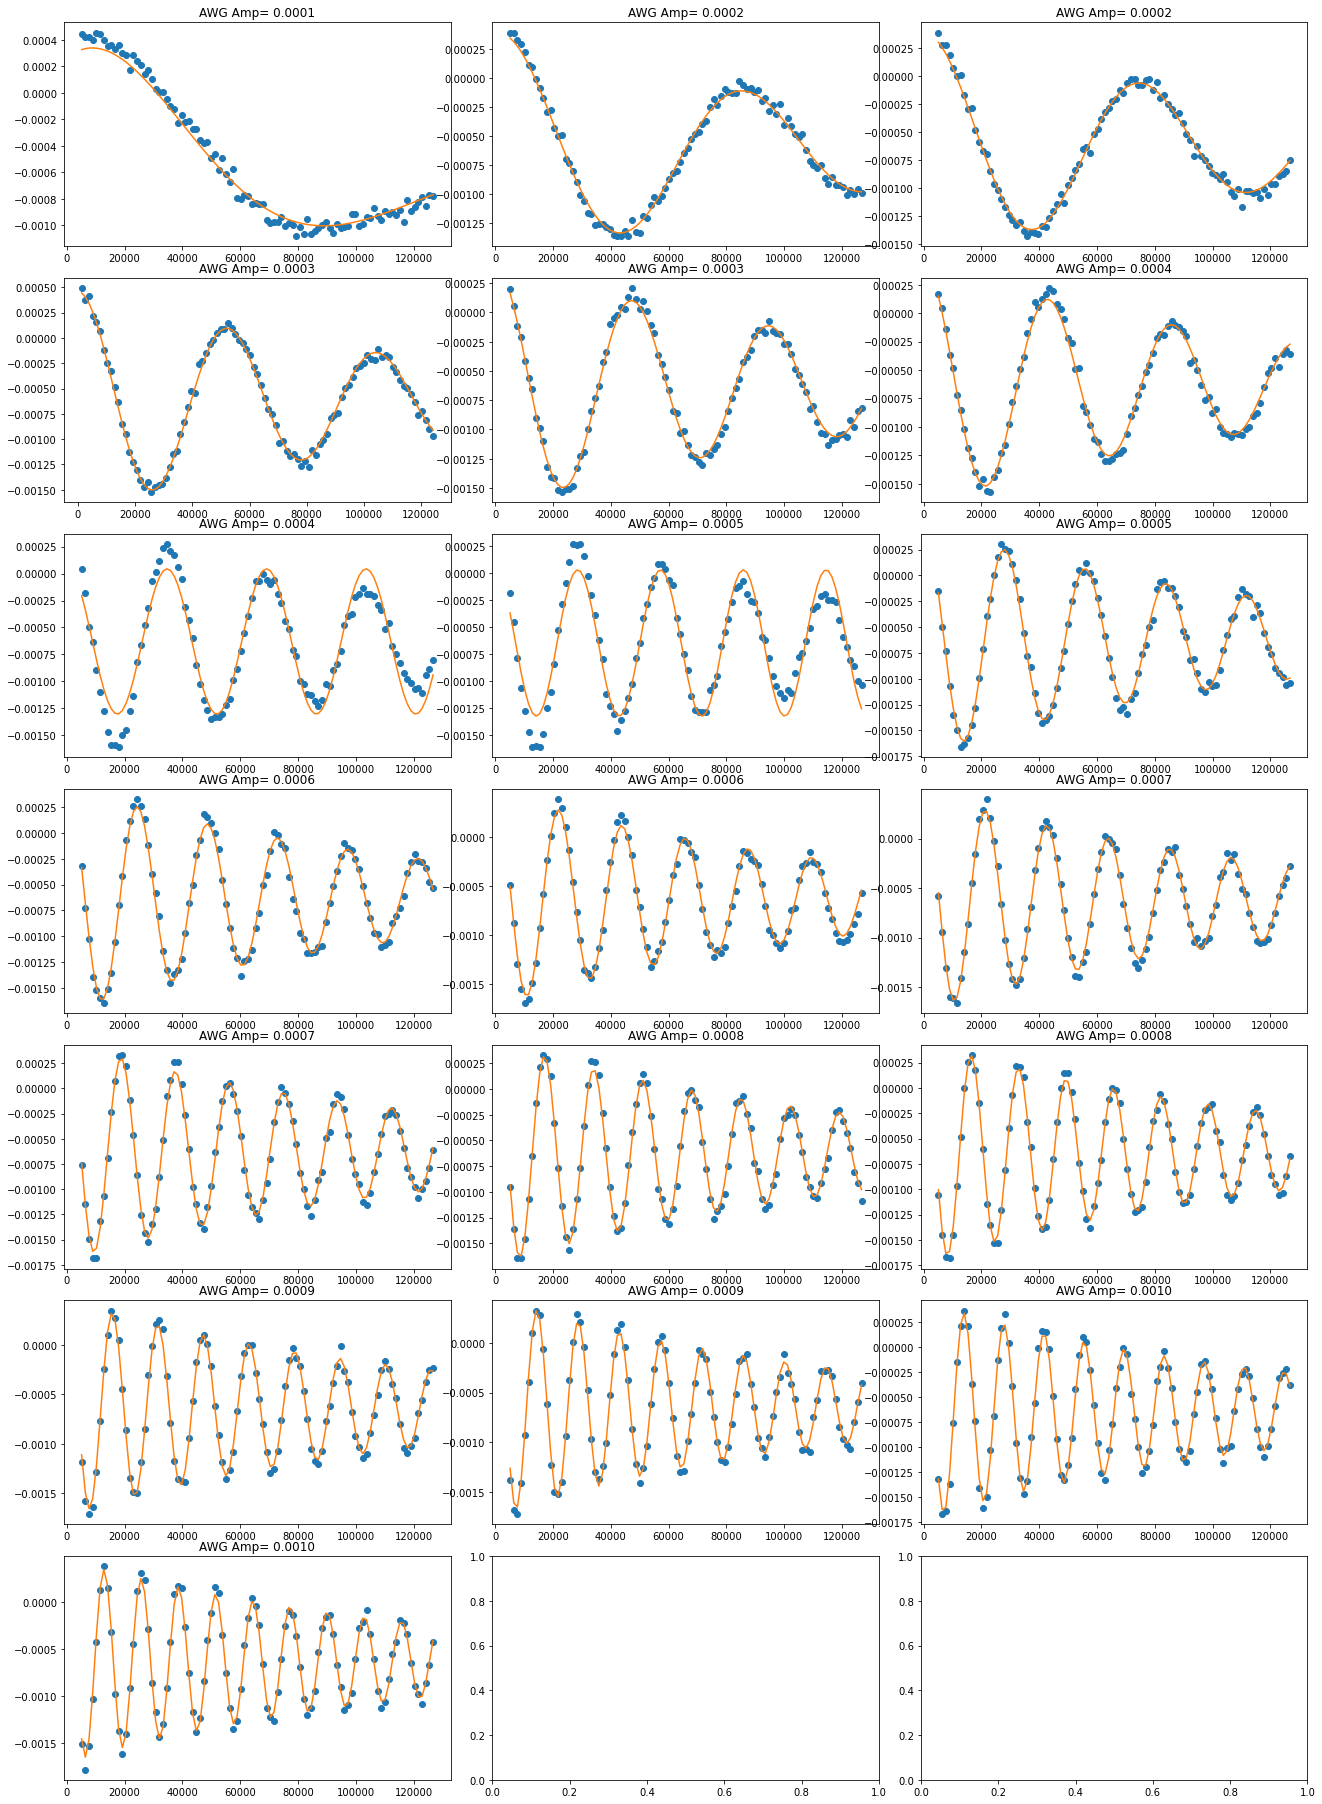

In [274]:
expt_name = 'qubit_square_cal'
filelist = [5, 6, 7, 8]
scs = []
scs_err = []
amps_q = []
xis_vs_amps = []
data_path = "S:\_Data\\210326 - QM_OPX\\data\\"
rabi_freqs = []

for ii, i in enumerate(filelist):
    
    filename = data_path+ str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:

        I = np.array(a['I'])
        Q = np.array(a['Q'])
        amp = np.array(a['amps'])
        times = np.array(a['times'])*1e3
        print(np.shape(I))
        a.close()
    amps_q.extend(amp)
    fig, axs = plt.subplots(nrows=len(amp)//3+len(amp)%3, ncols=3, figsize=(18, 4*len(amp)//3))
    fig.tight_layout()
    for jj in range(len(amp)):
        ax = axs[jj//3, jj%3]
        l = -1

        if i==5 and jj==2:
            k=2
        elif i==6 and jj==4 or 5 or 12:
            k = 4
        elif i==6 and jj==8 :
            k = 2
            l = -2
        else:
            k = 2

        if i==6 and jj==5 :

            k = 1
            l = -3
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=p, showfit=False)
        elif i==8 and jj==3 :

            k = 1
            l = -3
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=p, showfit=False)
            
            
        else:
            
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=None, showfit=False)
            
        ax.plot(t, y, 'o')
        ax.plot(t, decaysin(np.append(p, 0), t[:]))
        ax.set_title('AWG Amp= %.4f'%(amp[jj]))
        
        rabi_freqs.append(abs(p[1]))
    plt.show()

In [362]:
len(amp)//3+len(amp)%3-1

6

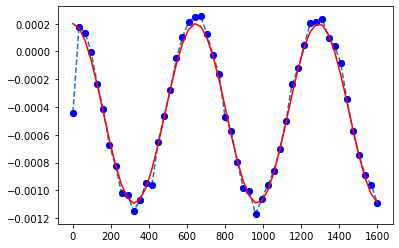

In [381]:
plt.plot(times, I[5], 'o--')
p = fitdecaysin(times, I[5], showfit=True)

In [370]:
1e3*max(rabi_freqs)

15.517029300344353

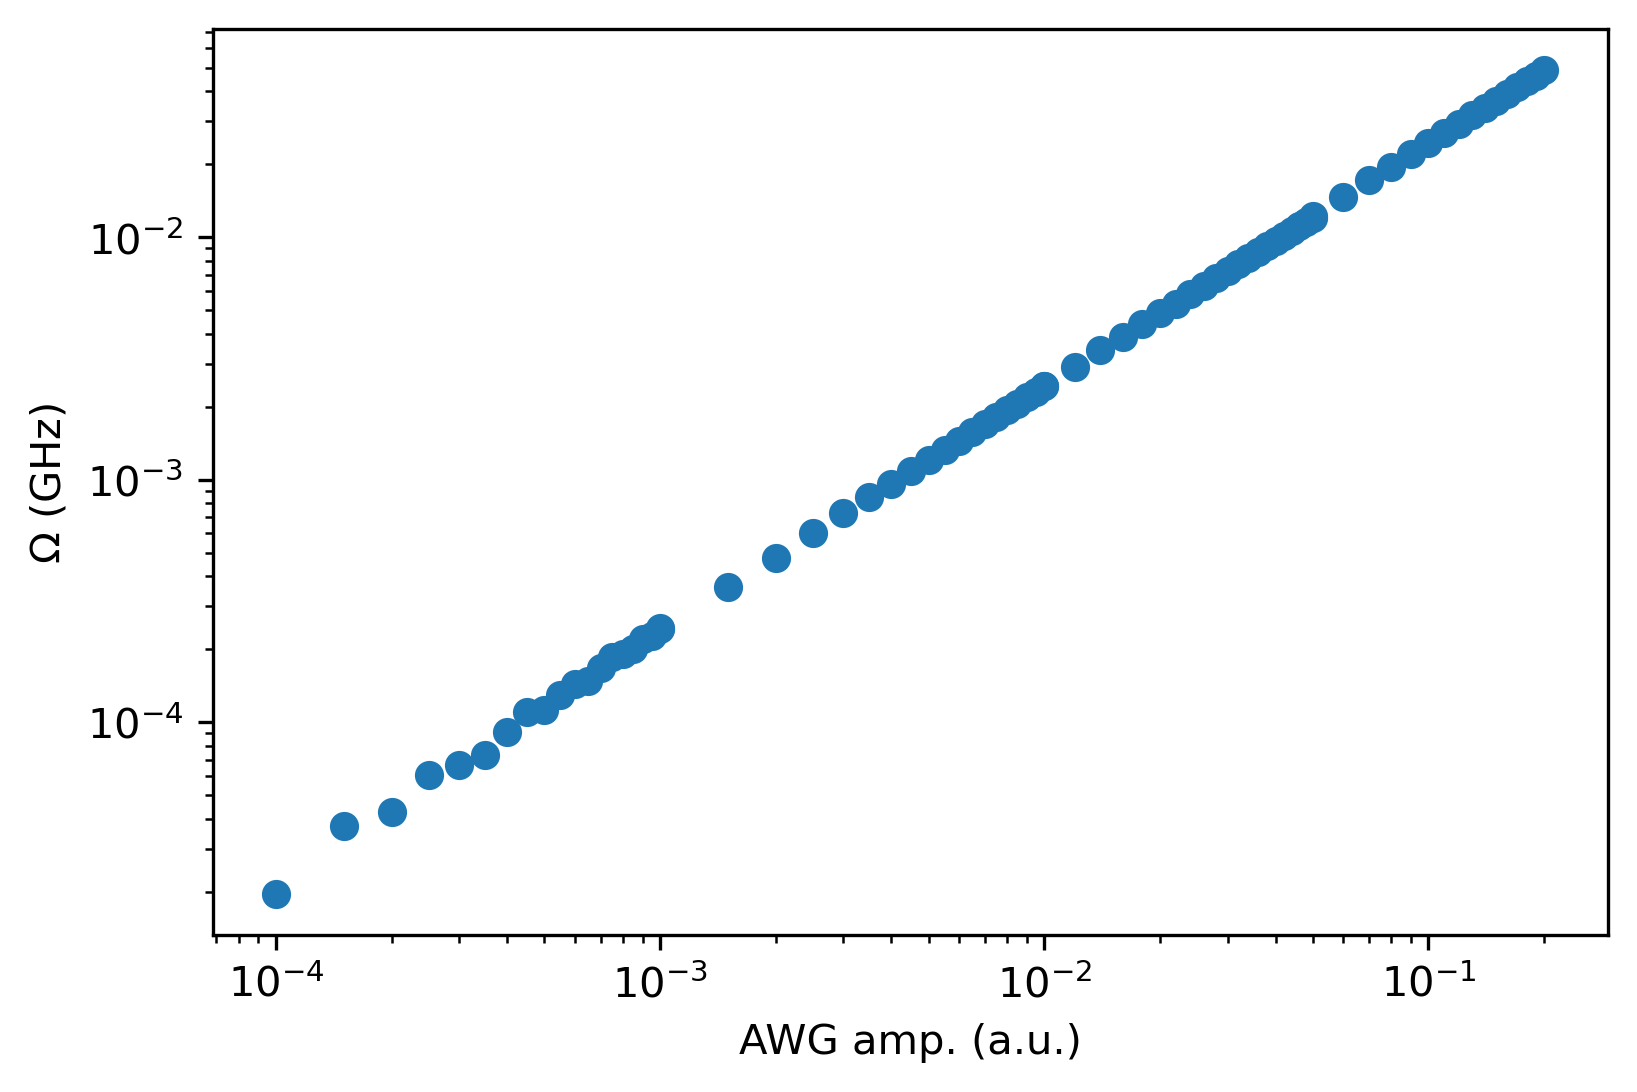

In [285]:
plt.figure(dpi=300)
omega = np.pi*np.array(rabi_freqs)
plt.loglog(amps_q, omega, 'o')
plt.xlabel('AWG amp. (a.u.)')
plt.ylabel(r'$\Omega$ (GHz)')
plt.show()

In [286]:
d = {'Amps': amps_q, 'Omegas': omega}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps    Omegas
15  0.20000  0.048748
14  0.19000  0.046309
13  0.18000  0.043869
12  0.17000  0.041445
11  0.16000  0.039033
..      ...       ...
60  0.00030  0.000066
59  0.00025  0.000060
58  0.00020  0.000042
57  0.00015  0.000037
56  0.00010  0.000020

[75 rows x 2 columns]

In [287]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'qubit_square'
file_number = 0

pulse_type = 'square'
date = '2021_03_29'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=omega)
    hf.create_dataset('amps', data=amps_q)
    hf.create_dataset('date', data=date)

print("done")

done


Text(0, 0.5, 'OPX Amp.')

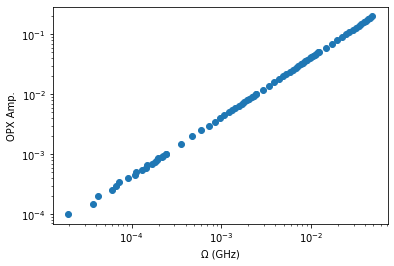

In [277]:
plt.loglog(omega, amps_q, 'o')
plt.xlabel('Ω (GHz)')
plt.ylabel('OPX Amp.')

# OCT Pulses

In [330]:
filename = '../oct_pulses/g1.h5'
with File(filename,'r') as a:
    Iq = array(a['uks'][-1][0])
    Qq = array(a['uks'][-1][1])
    Ic = array(a['uks'][-1][2])
    Qc = array(a['uks'][-1][3])

In [331]:
np.shape(I)

(6, 101)

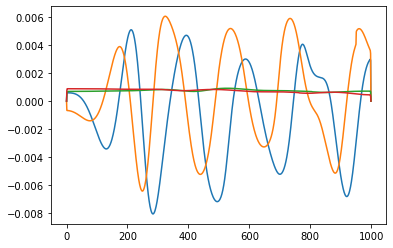

In [333]:
plt.plot(Iq)
plt.plot(Qq)
plt.plot(Ic)
plt.plot(Qc)
plt.show()

## Transfer Calibration

In [364]:
filename = '../drive_calibration/00000_2021_03_29_qubit_square.h5'
with File(filename,'r') as a:
    awg_amp_q = array(a['amps'])
    omega_q = array(a['omegas'])

# filename = '../drive_calibration/00000_2021_03_29_qubit_square.h5'
# with File(filename,'r') as a:
#     awg_amp_c = array(a['amps'])
#     omega_c = array(a['omegas'])

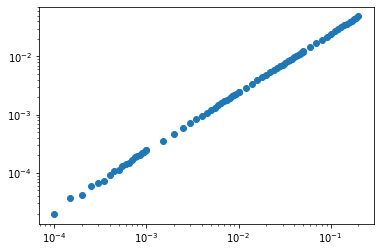

In [289]:
plt.loglog(awg_amp_q, omega_q, 'o')

In [366]:
def transfer_function(omegas_in, cavity=False, qubit=True, pulse_length=2000):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity

    if cavity==True:
        fn_file = '..\\drive_calibration\\00000_2021_04_01_cavity_square.h5'
    elif qubit==True:
        fn_file = '..\\drive_calibration\\00000_2021_03_29_qubit_square.h5'
        
    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, -omegas)
    amps = np.append(amps, -amps)
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)
    
    o_s = [x for y, x in sorted(zip(amps, omegas))]
    a_s = np.sort(amps)

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(o_s, a_s)
    output_amps = []
    max_interp_index = np.argmax(omegas)
    
    for i in range(len(omegas_in)):
        # if frequency greater than calibrated range, assume a proportional relationship (high amp)
        if np.abs(omegas_in[i]) > omegas[max_interp_index]:
            output_amps.append(omegas_in[i] * amps[max_interp_index] / omegas[max_interp_index])
        else:  # otherwise just use the interpolated transfer function
            output_amps.append(transfer_fn((omegas_in[i])))
    return np.array(output_amps)

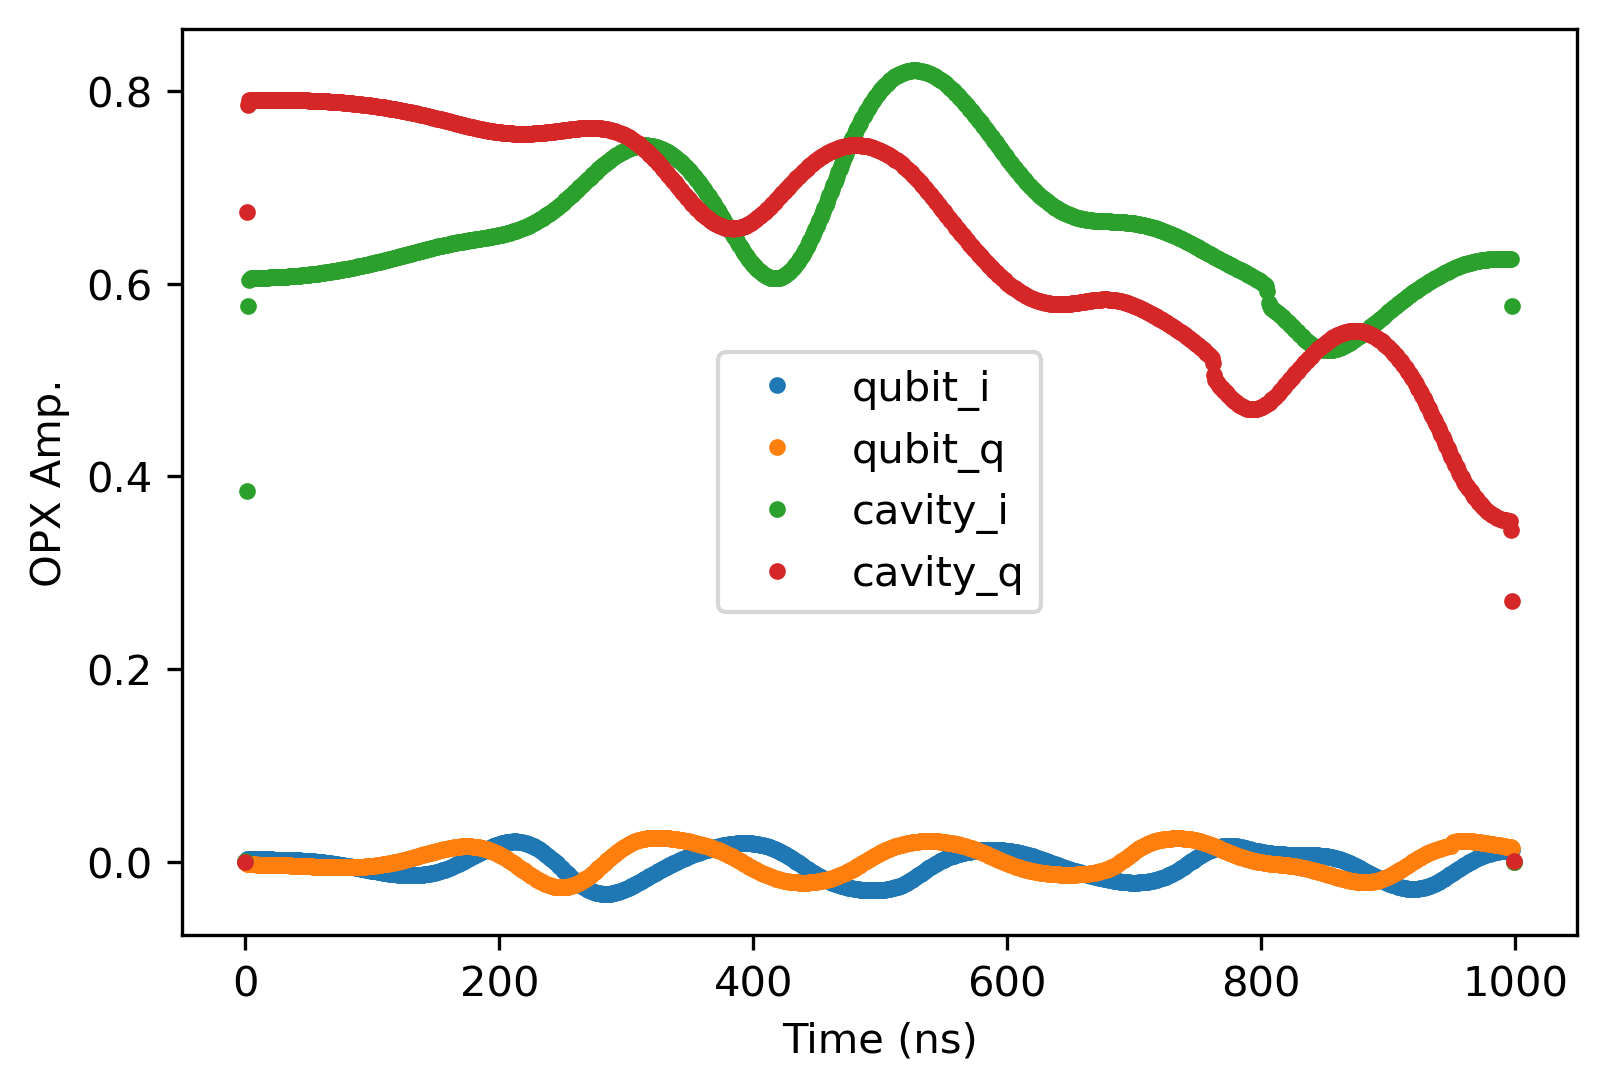

In [367]:
plt.figure(dpi=300)

plt.plot(transfer_function(Iq, qubit=True), '.', label='qubit_i')
plt.plot(transfer_function(Qq, qubit=True), '.',label='qubit_q')
plt.plot(transfer_function(Ic, cavity=True, qubit=False), '.', label='cavity_i')
plt.plot(transfer_function(Qc, cavity=True, qubit=False), '.', label='cavity_q')

plt.ylabel('OPX Amp.')
plt.xlabel('Time (ns)')
plt.legend()
plt.show()


In [341]:
len(Iq)

1000

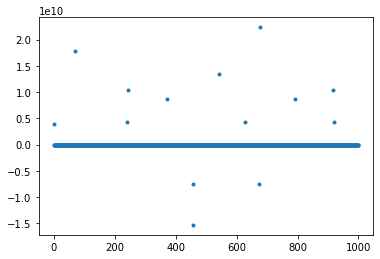

In [283]:
from scipy.interpolate import lagrange
import numpy as np
import matplotlib.pyplot as plt


funcs = []

####################
# measurement data #
####################
x = np.array([0, 1, 2, 3, 4, 5]) # rabi
y = 1.1*x+0.2 # amp
rabi = [0.5, 1.5, 2]
x = o
y = a
rabi = Iq

def amp_for_opx(rabi_cal, amp_cal, rabi):
    
    x = rabi_cal
    y = amp_cal
    
    #################
    # interpolation #
    #################
    funcs = []
    
    # left boundary (linear)
    poly = lagrange(x[0:2], y[0:2])
    funcs.append(poly)
    
#     if len(poly) != 2:
#         print('failed')


    # on the bulk (3order polynimial)
    for i in range(len(x)-3):
        poly = lagrange(x[i:i+4], y[i:i+4])
        funcs.append(poly)
        
#         if len(poly) != 4:
#             print('failed')

    # right boundary (linear)
    poly = lagrange(x[-2:], y[-2:])
    funcs.append(poly)
    
#     if len(poly) != 2:
#         print('failed')

#     print(funcs)
    
    amps = []
    for i in range(len(rabi)):
        amp_=0
        for j in range(len(rabi_cal)-1):
            
            if rabi[i]>=rabi_cal[j] and rabi[i]<rabi_cal[j+1]:
            
                if j==0 or j==len(rabi_cal)-1:
                    amp_ = funcs[j][0]*rabi[i]+funcs[j][1]
                else:
                    amp_ = funcs[j][0]*rabi[i]**3+funcs[j][1]*rabi[i]**2+funcs[j][2]*rabi[i]+funcs[j][3]
        amps.append(amp_)        
            
    return amps
    
amps_tr = amp_for_opx(x, y, rabi)

plt.plot(amps_tr,'.')
# plt.ylim(0, 0.0002)
# amps


In [256]:
poly[333333]

0

IndexError: list index out of range